Epoch [10/300], Loss: 0.6897, Val Loss: 0.6753
Epoch [20/300], Loss: 0.6046, Val Loss: 0.5909
Epoch [30/300], Loss: 0.5335, Val Loss: 0.5233
Epoch [40/300], Loss: 0.4630, Val Loss: 0.4519
Epoch [50/300], Loss: 0.3973, Val Loss: 0.3893
Epoch [60/300], Loss: 0.3475, Val Loss: 0.3411
Epoch [70/300], Loss: 0.2978, Val Loss: 0.2933
Epoch [80/300], Loss: 0.2543, Val Loss: 0.2509
Epoch [90/300], Loss: 0.2140, Val Loss: 0.2112
Epoch [100/300], Loss: 0.1792, Val Loss: 0.1778
Epoch [110/300], Loss: 0.1560, Val Loss: 0.1561
Epoch [120/300], Loss: 0.1448, Val Loss: 0.1459
Epoch [130/300], Loss: 0.1379, Val Loss: 0.1386
Epoch [140/300], Loss: 0.1320, Val Loss: 0.1332
Epoch [150/300], Loss: 0.1270, Val Loss: 0.1282
Epoch [160/300], Loss: 0.1228, Val Loss: 0.1241
Epoch [170/300], Loss: 0.1191, Val Loss: 0.1204
Epoch [180/300], Loss: 0.1172, Val Loss: 0.1192
Epoch [190/300], Loss: 0.1141, Val Loss: 0.1157
Epoch [200/300], Loss: 0.1116, Val Loss: 0.1130
Epoch [210/300], Loss: 0.1096, Val Loss: 0.1113
E

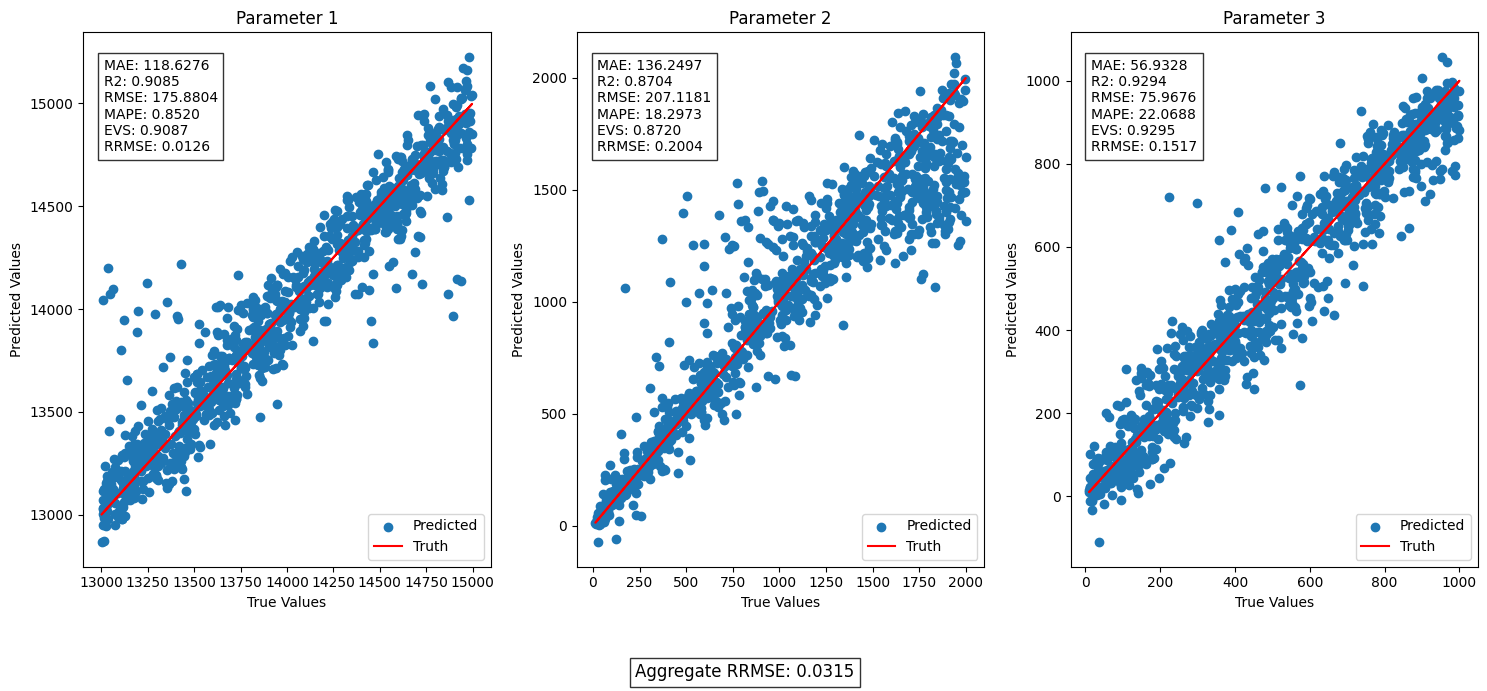

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, explained_variance_score
import matplotlib.pyplot as plt

# Load the data
file_path = '/nas/longleaf/home/adaigle/work/ghist_2024_work/bottleneck_restricted/results/reference_table.txt'
df = pd.read_csv(file_path, sep='\t')  # Adjust the separator if necessary

# Save the first 100 rows for later prediction
df_first_100 = df.iloc[:1000, :]

# Assuming the first three columns are target variables and the rest are features
X = df.iloc[:, 3:].values  # Features (summary statistics)
y = df.iloc[:, :3].values  # Targets (first three columns)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale both features and targets using StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)

y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)

# Convert the scaled data back to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(input_size, 128)  # First hidden layer with 128 neurons
        self.hidden2 = nn.Linear(128, 64)         # Second hidden layer with 64 neurons
        self.output = nn.Linear(64, output_size)  # Output layer with 3 neurons (one for each target variable)
        self.relu = nn.ReLU(0.01)  # LeakyReLU allows a small slope for negative values

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.output(x)
        return x

class MLPWithMoreLayers(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLPWithMoreLayers, self).__init__()
        # First fully connected layer
        self.fc1 = nn.Linear(input_size, 256)  # Increased number of neurons
        self.dropout1 = nn.Dropout(0.5)
        # Second fully connected layer
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.5)
        # Third fully connected layer
        self.fc3 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(0.5)
        # Fourth fully connected layer (optional)
        self.fc4 = nn.Linear(64, 32)
        self.dropout4 = nn.Dropout(0.5)
        # Output layer
        self.output = nn.Linear(32, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # First layer + ReLU
        x = self.dropout1(x)         # Dropout after first layer
        x = torch.relu(self.fc2(x))  # Second layer + ReLU
        x = self.dropout2(x)         # Dropout after second layer
        x = torch.relu(self.fc3(x))  # Third layer + ReLU
        x = self.dropout3(x)         # Dropout after third layer
        x = torch.relu(self.fc4(x))  # Fourth layer + ReLU
        x = self.dropout4(x)         # Dropout after fourth layer
        x = self.output(x)           # Output layer (no activation for regression)
        return x

# Initialize the model
input_size = X_train.shape[1]
output_size = y_train.shape[1]
model = MLP(input_size, output_size)

# Loss function and optimizer
criterion = nn.MSELoss()
def rrmse_loss(y_pred, y_true, epsilon=1e-8):
    # Log transformation to stabilize the loss calculation
    y_pred_log = torch.log1p(y_pred)
    y_true_log = torch.log1p(y_true)
    return torch.sqrt(torch.mean(((y_pred_log - y_true_log) / (y_true_log + epsilon)) ** 2))
#criterion = nn.SmoothL1Loss()  # Huber loss in PyTorch

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    #loss = rrmse_loss(outputs, y_train_tensor)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Validation
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            #val_loss = rrmse_loss(val_outputs, y_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Predict using the first 100 rows
X_first_100 = df_first_100.iloc[:, 3:].values
X_first_100_scaled = scaler_X.transform(X_first_100)
X_first_100_tensor = torch.tensor(X_first_100_scaled, dtype=torch.float32)

# Make predictions
model.eval()
with torch.no_grad():
    predictions_scaled = model(X_first_100_tensor).numpy()

# Inverse transform the scaled predictions and true values
predictions = scaler_y.inverse_transform(predictions_scaled)
true_values = df_first_100.iloc[:, :3].values

# Calculate metrics for each target
def compute_metrics(true, pred):
    metrics = []
    for i in range(true.shape[1]):
        mae = mean_absolute_error(true[:, i], pred[:, i])
        rmse = np.sqrt(mean_squared_error(true[:, i], pred[:, i]))
        r2 = r2_score(true[:, i], pred[:, i])
        mape = np.mean(np.abs((true[:, i] - pred[:, i]) / true[:, i])) * 100
        evs = explained_variance_score(true[:, i], pred[:, i])
        rrmse = rmse / np.mean(np.abs(true[:, i]))

        metrics.append({
            "mae": mae,
            "rmse": rmse,
            "r2": r2,
            "mape": mape,
            "evs": evs,
            "rrmse": rrmse
        })
    return metrics

# Calculate metrics for each parameter
metrics = compute_metrics(true_values, predictions)

# Plot the results
def plot_results(metrics, all_true_values, all_predicted_means, num_parameters):
    fig, axes = plt.subplots(1, num_parameters, figsize=(15, 7))
    
    for i in range(num_parameters):
        true_values = all_true_values[:, i]
        predicted_values = all_predicted_means[:, i]
        
        axes[i].scatter(true_values, predicted_values, label='Predicted')
        axes[i].plot(true_values, true_values, 'r-', label='Truth')
        axes[i].set_title(f'Parameter {i+1}')
        axes[i].set_xlabel('True Values')
        axes[i].set_ylabel('Predicted Values')
        axes[i].legend(loc='lower right')
        
        # Display metrics
        metrics_text = (
            f'MAE: {metrics[i]["mae"]:.4f}\n'
            f'R2: {metrics[i]["r2"]:.4f}\n'
            f'RMSE: {metrics[i]["rmse"]:.4f}\n'
            f'MAPE: {metrics[i]["mape"]:.4f}\n'
            f'EVS: {metrics[i]["evs"]:.4f}\n'
            f'RRMSE: {metrics[i]["rrmse"]:.4f}'
        )
        axes[i].text(0.05, 0.95, metrics_text, transform=axes[i].transAxes, verticalalignment='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout(rect=[0, 0.1, 1, 1])
    
    # Compute aggregate metrics
    aggregate_metrics = compute_metrics(all_true_values.reshape(-1, 1), all_predicted_means.reshape(-1, 1))
    aggregate_text = (
        f'Aggregate RRMSE: {aggregate_metrics[0]["rrmse"]:.4f}'
    )
    fig.text(0.5, 0.02, aggregate_text, ha='center', va='bottom', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    
    return plt

# Plot the results
plot = plot_results(metrics, true_values, predictions, 3)
plot.show()

In [1]:
import os
import glob
import pandas as pd

# Directories
stats_dir = '/nas/longleaf/home/adaigle/work/ghist_2024_work/bottleneck_testing_ground_pt2/bottleneck/stats/'
#stats_dir2 = '/nas/longleaf/home/adaigle/work/ghist_2024_work/bottleneck_testing_ground_pt2/bottleneck/stats_50k/'
logs_dir = '/nas/longleaf/home/adaigle/work/ghist_2024_work/bottleneck_testing_ground_pt2/bottleneck/vcfs/'
plot_dir = '/nas/longleaf/home/adaigle/work/ghist_2024_work/bottleneck_testing_ground_pt2/bottleneck/plots/'
os.makedirs(plot_dir, exist_ok=True)

# Load the log files
log_files = glob.glob(os.path.join(logs_dir, '*.tsv'))
log_data = []
for log_file in log_files:
    repnum = int(os.path.basename(log_file).split('_')[1].split('.')[0])
    log_df = pd.read_csv(log_file, sep='\t', header=None, names=['repnum', 'Nanc', 'Nbot', 't'])
    log_df['repnum'] = repnum
    log_data.append(log_df)
logs_df = pd.concat(log_data, ignore_index=True)
print('Log data loaded.')

# Load the stats files from `stats_dir`
stats_files = glob.glob(os.path.join(stats_dir, '*.stats'))
stats_data = []
for stats_file in stats_files:
    repnum = int(os.path.basename(stats_file).split('_')[1].split('.')[0])
    stats_df = pd.read_csv(stats_file, sep='\t')
    stats_df['repnum'] = repnum
    stats_data.append(stats_df)
stats_df = pd.concat(stats_data, ignore_index=True)
print('Stats data from stats_dir loaded.')
#remove redundant sfs and ld from first dataset
#stats_df = stats_df.loc[:, ~stats_df.columns.str.startswith(('sfs', 'ld'))]

# Load the stats files from `stats_dir2` with suffixes for overlapping columns
#stats_files_1mil = glob.glob(os.path.join(stats_dir2, '*.stats'))
#stats_data_1mil = []
#for stats_file in stats_files_1mil:
#    repnum = int(os.path.basename(stats_file).split('_')[1].split('.')[0])
#    stats_df_1mil = pd.read_csv(stats_file, sep='\t')
#    stats_df_1mil['repnum'] = repnum
#    
#    # Add '1mil' suffix to any columns that overlap with `stats_df`
#    overlapping_columns = set(stats_df.columns).intersection(stats_df_1mil.columns) - {'repnum'}
#    stats_df_1mil = stats_df_1mil.rename(columns={col: f"{col}_1mil" for col in overlapping_columns})
#    stats_data_1mil.append(stats_df_1mil)
#
## Concatenate the `stats_dir2` data
#stats_df_1mil = pd.concat(stats_data_1mil, ignore_index=True)
#print('Stats data from stats_dir2 loaded with suffixes.')

# Merge the two stats DataFrames on 'repnum'
#combined_stats_df = pd.merge(stats_df, on='repnum', how='outer')
#print('Combined stats DataFrame created.')

# Merge the combined stats with the logs data
df = pd.merge(stats_df, logs_df, on='repnum', how='outer')
print('Final combined DataFrame created.')

# Define parameter and feature columns
parameter_columns = ['Nanc', 'Nbot', 't']
feature_columns = [col for col in df.columns if col != 'repnum']

Log data loaded.
Stats data from stats_dir loaded.
Final combined DataFrame created.


In [75]:
print(feature_columns)
print("Column names in df:", df.columns.tolist())
X = df_remaining[feature_columns].values
y = df_remaining[parameter_columns].values
print(len(X[1]))
print(len(feature_columns))

['thetapi_mean', 'thetapi_median', 'thetapi_sd', 'thetapi_iqr', 'hprime_mean', 'hprime_median', 'hprime_sd', 'hprime_iqr', 'thetaw_mean', 'thetaw_median', 'thetaw_sd', 'thetaw_iqr', 'faywuh_mean', 'faywuh_median', 'faywuh_sd', 'faywuh_iqr', 'tajd_mean', 'tajd_median', 'tajd_sd', 'tajd_iqr', 'haplotype_diversity_mean', 'haplotype_diversity_median', 'haplotype_diversity_sd', 'haplotype_diversity_iqr', 'number_of_haplotypes_mean', 'number_of_haplotypes_median', 'number_of_haplotypes_sd', 'number_of_haplotypes_iqr', 'fROH_mean', 'fROH_median', 'fROH_sd', 'fROH_iqr', 'sfs_1', 'sfs_2', 'sfs_3', 'sfs_4', 'sfs_5', 'sfs_6', 'sfs_7', 'sfs_8', 'sfs_9', 'sfs_10', 'sfs_11', 'sfs_12', 'sfs_13', 'sfs_14', 'sfs_15', 'sfs_16', 'sfs_17', 'sfs_18', 'sfs_19', 'sfs_20', 'sfs_21', 'sfs_22', 'sfs_23', 'sfs_24', 'sfs_25', 'sfs_26', 'sfs_27', 'sfs_28', 'sfs_29', 'sfs_30', 'sfs_31', 'sfs_32', 'sfs_33', 'sfs_34', 'sfs_35', 'sfs_36', 'sfs_37', 'sfs_38', 'sfs_39', 'sfs_40', 'sfs_41', 'ld_decay_50bp', 'ld_decay_150

['thetapi_mean', 'thetapi_median', 'thetapi_sd', 'thetapi_iqr', 'hprime_mean', 'hprime_median', 'hprime_sd', 'hprime_iqr', 'thetaw_mean', 'thetaw_median', 'thetaw_sd', 'thetaw_iqr', 'faywuh_mean', 'faywuh_median', 'faywuh_sd', 'faywuh_iqr', 'tajd_mean', 'tajd_median', 'tajd_sd', 'tajd_iqr', 'haplotype_diversity_mean', 'haplotype_diversity_median', 'haplotype_diversity_sd', 'haplotype_diversity_iqr', 'number_of_haplotypes_mean', 'number_of_haplotypes_median', 'number_of_haplotypes_sd', 'number_of_haplotypes_iqr', 'fROH_mean', 'fROH_median', 'fROH_sd', 'fROH_iqr', 'sfs_1', 'sfs_2', 'sfs_3', 'sfs_4', 'sfs_5', 'sfs_6', 'sfs_7', 'sfs_8', 'sfs_9', 'sfs_10', 'sfs_11', 'sfs_12', 'sfs_13', 'sfs_14', 'sfs_15', 'sfs_16', 'sfs_17', 'sfs_18', 'sfs_19', 'sfs_20', 'sfs_21', 'sfs_22', 'sfs_23', 'sfs_24', 'sfs_25', 'sfs_26', 'sfs_27', 'sfs_28', 'sfs_29', 'sfs_30', 'sfs_31', 'sfs_32', 'sfs_33', 'sfs_34', 'sfs_35', 'sfs_36', 'sfs_37', 'sfs_38', 'sfs_39', 'sfs_40', 'sfs_41', 'ld_decay_50bp', 'ld_decay_150

/work/users/a/d/adaigle/.conda/envs/myenv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/1000], Loss: 0.6130, Val Loss: 0.5998
Epoch [20/1000], Loss: 0.4288, Val Loss: 0.4225
Epoch [30/1000], Loss: 0.2933, Val Loss: 0.2880
Epoch [40/1000], Loss: 0.2171, Val Loss: 0.2215
Epoch [50/1000], Loss: 0.1638, Val Loss: 0.1686
Epoch [60/1000], Loss: 0.1260, Val Loss: 0.1287
Epoch [70/1000], Loss: 0.1049, Val Loss: 0.1082
Epoch [80/1000], Loss: 0.0897, Val Loss: 0.0928
Epoch [90/1000], Loss: 0.0778, Val Loss: 0.0813
Epoch [100/1000], Loss: 0.0696, Val Loss: 0.0735
Epoch [110/1000], Loss: 0.0634, Val Loss: 0.0677
Epoch [120/1000], Loss: 0.0588, Val Loss: 0.0636
Epoch [130/1000], Loss: 0.0552, Val Loss: 0.0603
Epoch [140/1000], Loss: 0.0522, Val Loss: 0.0576
Epoch [150/1000], Loss: 0.0501, Val Loss: 0.0557
Epoch [160/1000], Loss: 0.0481, Val Loss: 0.0535
Epoch [170/1000], Loss: 0.0460, Val Loss: 0.0520
Epoch [180/1000], Loss: 0.0443, Val Loss: 0.0503
Epoch [190/1000], Loss: 0.0429, Val Loss: 0.0490
Epoch [200/1000], Loss: 0.0416, Val Loss: 0.0478
Epoch [210/1000], Loss: 0.040

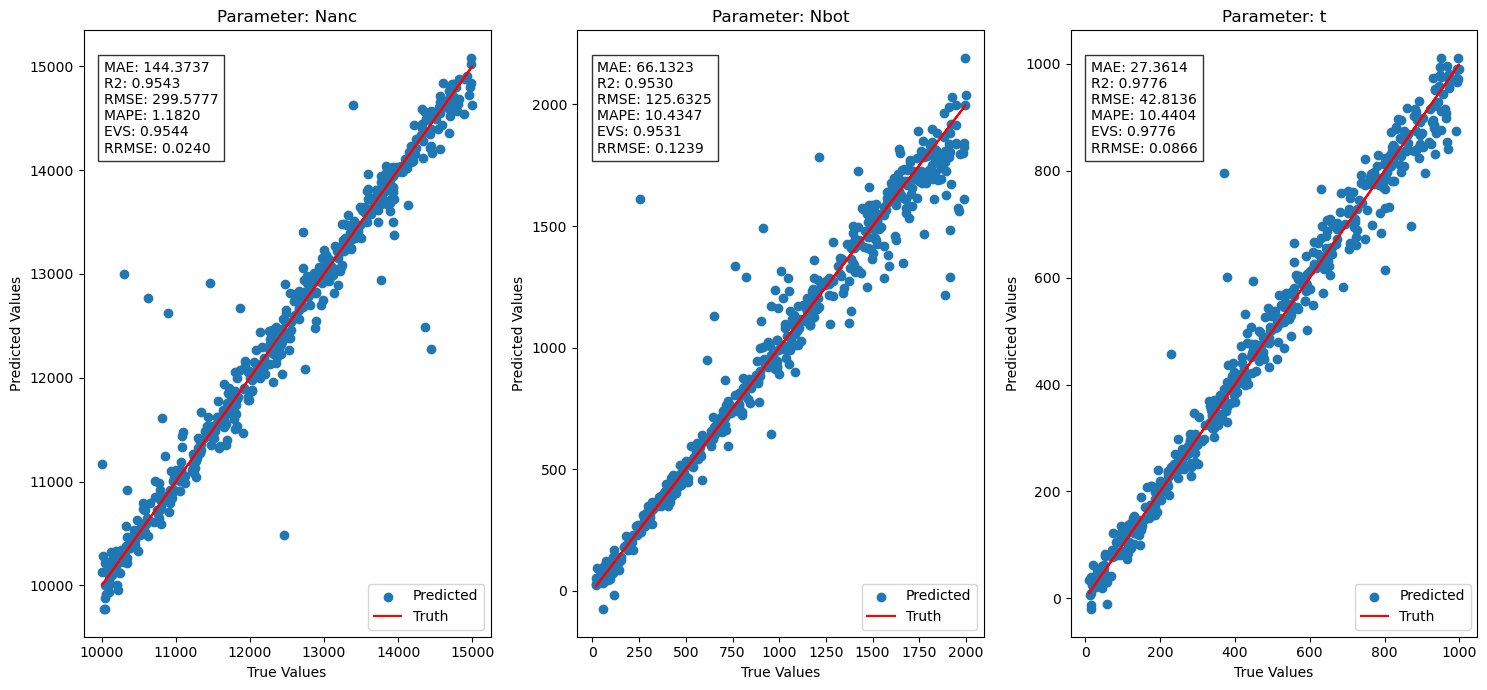

In [2]:
import os
import glob
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, explained_variance_score
import matplotlib.pyplot as plt
import re


# Separate the first 100 rows for later prediction
df_first_100 = df.iloc[:500, :]
df_remaining = df.iloc[500:, :]
# Define X and y for the remaining data
print(feature_columns)
feature_columns = [col for col in feature_columns if col not in parameter_columns]
print(feature_columns)
feature_columns = [
    col for col in feature_columns 
    if not (col.startswith("ld_decay_") and int(re.search(r"\d+", col).group()) > 1000)
]

X = df_remaining[feature_columns].values
y = df_remaining[parameter_columns].values

# Split the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale both features and targets
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)

y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)

# Convert the scaled data to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32)

# Define a simplified MLP model similar to the original architecture
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        
        self.hidden1 = nn.Linear(input_size, 128)
        self.hidden2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, output_size)
        self.relu = nn.LeakyReLU(0.01)

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.output(x)
        return x

# Initialize the model
input_size = X_train.shape[1]
output_size = y_train.shape[1]
model = MLP(input_size, output_size)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler and early stopping
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=10, verbose=True)
early_stopping_patience = 20
best_val_loss = float('inf')
epochs_without_improvement = 0

# Training loop with early stopping and learning rate scheduler
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

    # Learning rate scheduler step
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1  # Increment counter if no improvement

    # Stop training if no improvement for `early_stopping_patience` epochs
    if epochs_without_improvement >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch + 1} with validation loss {val_loss:.4f}")
        break

# Predict using the first 100 rows
X_first_100 = df_first_100[feature_columns].values
X_first_100_scaled = scaler_X.transform(X_first_100)
X_first_100_tensor = torch.tensor(X_first_100_scaled, dtype=torch.float32)

# Make predictions
model.eval()
with torch.no_grad():
    predictions_scaled = model(X_first_100_tensor).numpy()

# Inverse transform the scaled predictions and true values
predictions = scaler_y.inverse_transform(predictions_scaled)
true_values = df_first_100[parameter_columns].values

# Calculate metrics for each target
def compute_metrics(true, pred):
    metrics = []
    for i in range(true.shape[1]):
        mae = mean_absolute_error(true[:, i], pred[:, i])
        rmse = np.sqrt(mean_squared_error(true[:, i], pred[:, i]))
        r2 = r2_score(true[:, i], pred[:, i])
        mape = np.mean(np.abs((true[:, i] - pred[:, i]) / true[:, i])) * 100
        evs = explained_variance_score(true[:, i], pred[:, i])
        rrmse = rmse / np.mean(np.abs(true[:, i]))

        metrics.append({
            "mae": mae,
            "rmse": rmse,
            "r2": r2,
            "mape": mape,
            "evs": evs,
            "rrmse": rrmse
        })
    return metrics

metrics = compute_metrics(true_values, predictions)

# Plot the results
def plot_results(metrics, all_true_values, all_predicted_means, parameter_names):
    num_parameters = len(parameter_names)
    fig, axes = plt.subplots(1, num_parameters, figsize=(5 * num_parameters, 7))
    
    if num_parameters == 1:
        axes = [axes]
    
    for i in range(num_parameters):
        true_values = all_true_values[:, i]
        predicted_values = all_predicted_means[:, i]
        
        axes[i].scatter(true_values, predicted_values, label='Predicted')
        axes[i].plot(true_values, true_values, 'r-', label='Truth')
        axes[i].set_title(f'Parameter: {parameter_names[i]}')
        axes[i].set_xlabel('True Values')
        axes[i].set_ylabel('Predicted Values')
        axes[i].legend(loc='lower right')
        
        # Display metrics
        metrics_text = (
            f'MAE: {metrics[i]["mae"]:.4f}\n'
            f'R2: {metrics[i]["r2"]:.4f}\n'
            f'RMSE: {metrics[i]["rmse"]:.4f}\n'
            f'MAPE: {metrics[i]["mape"]:.4f}\n'
            f'EVS: {metrics[i]["evs"]:.4f}\n'
            f'RRMSE: {metrics[i]["rrmse"]:.4f}'
        )
        axes[i].text(0.05, 0.95, metrics_text, transform=axes[i].transAxes, verticalalignment='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    # Save the plot
    plt.savefig(os.path.join(plot_dir, 'parameter_predictions_mlp_1mil.png'))
    plt.show()

parameter_names = parameter_columns
plot_results(metrics, true_values, predictions, parameter_names)

Index(['thetapi_mean', 'thetapi_median', 'thetapi_sd', 'thetapi_iqr',
       'hprime_mean', 'hprime_median', 'hprime_sd', 'hprime_iqr',
       'thetaw_mean', 'thetaw_median', 'thetaw_sd', 'thetaw_iqr',
       'faywuh_mean', 'faywuh_median', 'faywuh_sd', 'faywuh_iqr', 'tajd_mean',
       'tajd_median', 'tajd_sd', 'tajd_iqr', 'haplotype_diversity_mean',
       'haplotype_diversity_median', 'haplotype_diversity_sd',
       'haplotype_diversity_iqr', 'number_of_haplotypes_mean',
       'number_of_haplotypes_median', 'number_of_haplotypes_sd',
       'number_of_haplotypes_iqr', 'fROH_mean', 'fROH_median', 'fROH_sd',
       'fROH_iqr', 'sfs_1', 'sfs_2', 'sfs_3', 'sfs_4', 'sfs_5', 'sfs_6',
       'sfs_7', 'sfs_8', 'sfs_9', 'sfs_10', 'sfs_11', 'sfs_12', 'sfs_13',
       'sfs_14', 'sfs_15', 'sfs_16', 'sfs_17', 'sfs_18', 'sfs_19', 'sfs_20',
       'sfs_21', 'sfs_22', 'sfs_23', 'sfs_24', 'sfs_25', 'sfs_26', 'sfs_27',
       'sfs_28', 'sfs_29', 'sfs_30', 'sfs_31', 'sfs_32', 'sfs_33', 'sfs_34',
   

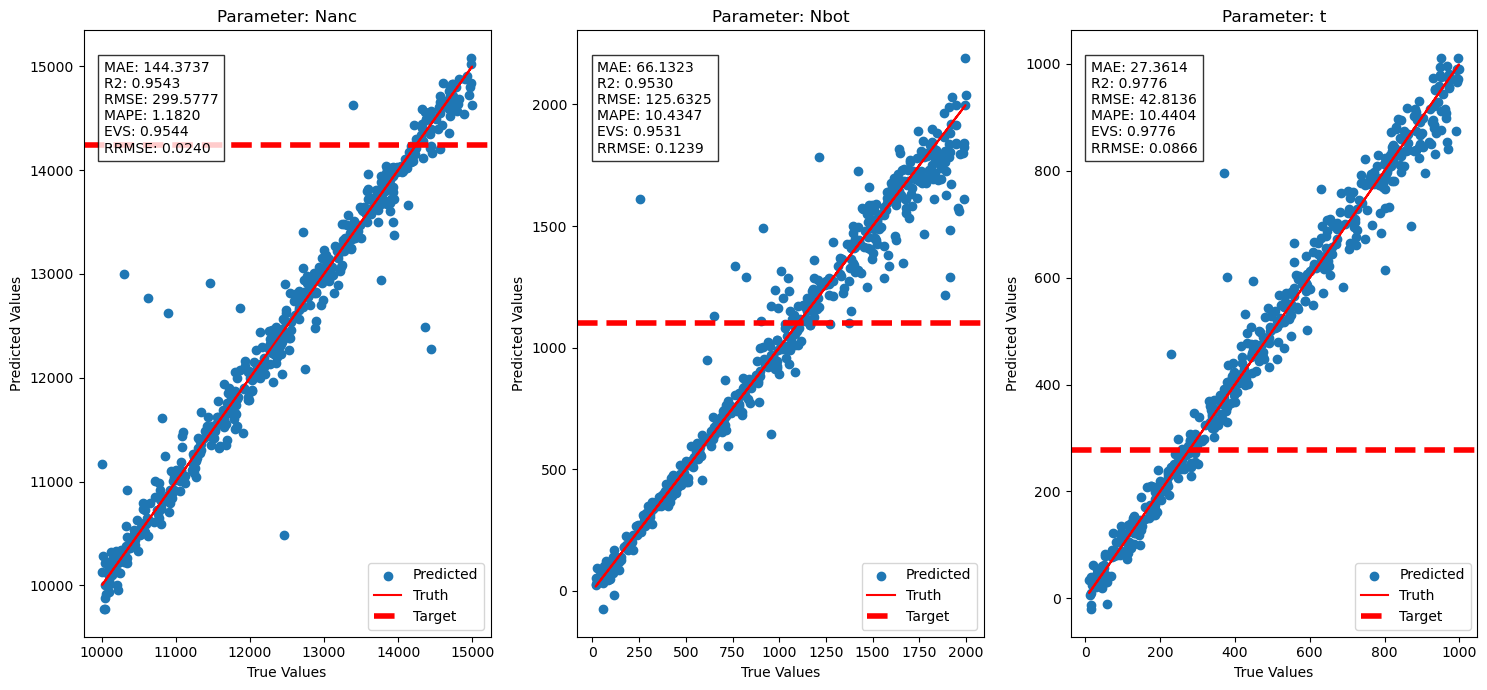

In [3]:
# Load the target stats file with only feature columns (not parameters)
target_stats_path = '/nas/longleaf/home/adaigle/work/ghist_2024_work/bottleneck_testing_ground_pt2/bottleneck/target/target.stats'
target_df = pd.read_csv(target_stats_path, sep='\t')

print(target_df.columns)
print(feature_columns)
target_features = target_df[feature_columns].values  # Extract only feature columns
print(target_features)

# Scale the target features
target_features_scaled = scaler_X.transform(target_features)
target_features_tensor = torch.tensor(target_features_scaled, dtype=torch.float32)

# Predict parameter values for the target stats
model.eval()
with torch.no_grad():
    target_predictions_scaled = model(target_features_tensor).numpy()

# Inverse transform to get predictions in the original scale
target_predictions = scaler_y.inverse_transform(target_predictions_scaled)

# Define the parameter names
parameter_names = ['Nanc', 'N_bot', 'T']

# Print each parameter with its value, ensuring no scientific notation
for name, value in zip(parameter_names, target_predictions[0]):
    print(f"{name}: {value:.5f}")  # Adjust the number of decimals as needed
# Calculate metrics for each target
def compute_metrics(true, pred):
    metrics = []
    for i in range(true.shape[1]):
        mae = mean_absolute_error(true[:, i], pred[:, i])
        rmse = np.sqrt(mean_squared_error(true[:, i], pred[:, i]))
        r2 = r2_score(true[:, i], pred[:, i])
        mape = np.mean(np.abs((true[:, i] - pred[:, i]) / true[:, i])) * 100
        evs = explained_variance_score(true[:, i], pred[:, i])
        rrmse = rmse / np.mean(np.abs(true[:, i]))

        metrics.append({
            "mae": mae,
            "rmse": rmse,
            "r2": r2,
            "mape": mape,
            "evs": evs,
            "rrmse": rrmse
        })
    return metrics

metrics = compute_metrics(true_values, predictions)

# Plot the results
def plot_results(metrics, all_true_values, all_predicted_means, parameter_names, target_values):
    num_parameters = len(parameter_names)
    fig, axes = plt.subplots(1, num_parameters, figsize=(5 * num_parameters, 7))
    
    if num_parameters == 1:
        axes = [axes]
    
    for i in range(num_parameters):
        true_values = all_true_values[:, i]
        predicted_values = all_predicted_means[:, i]
        
        axes[i].scatter(true_values, predicted_values, label='Predicted')
        axes[i].plot(true_values, true_values, 'r-', label='Truth')
        axes[i].axhline(y=target_values[i], color='r', linestyle='--', linewidth=4, label='Target')  # Add dotted line for target value
        
        axes[i].set_title(f'Parameter: {parameter_names[i]}')
        axes[i].set_xlabel('True Values')
        axes[i].set_ylabel('Predicted Values')
        axes[i].legend(loc='lower right')
        
        # Display metrics
        metrics_text = (
            f'MAE: {metrics[i]["mae"]:.4f}\n'
            f'R2: {metrics[i]["r2"]:.4f}\n'
            f'RMSE: {metrics[i]["rmse"]:.4f}\n'
            f'MAPE: {metrics[i]["mape"]:.4f}\n'
            f'EVS: {metrics[i]["evs"]:.4f}\n'
            f'RRMSE: {metrics[i]["rrmse"]:.4f}'
        )
        axes[i].text(0.05, 0.95, metrics_text, transform=axes[i].transAxes, verticalalignment='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    # Save the plot
    #plt.savefig(os.path.join(plot_dir, 'parameter_predictions_mlp_1mil_with_target.png'))
    plt.show()

parameter_names = parameter_columns
plot_results(metrics, true_values, predictions, parameter_names, target_predictions[0])

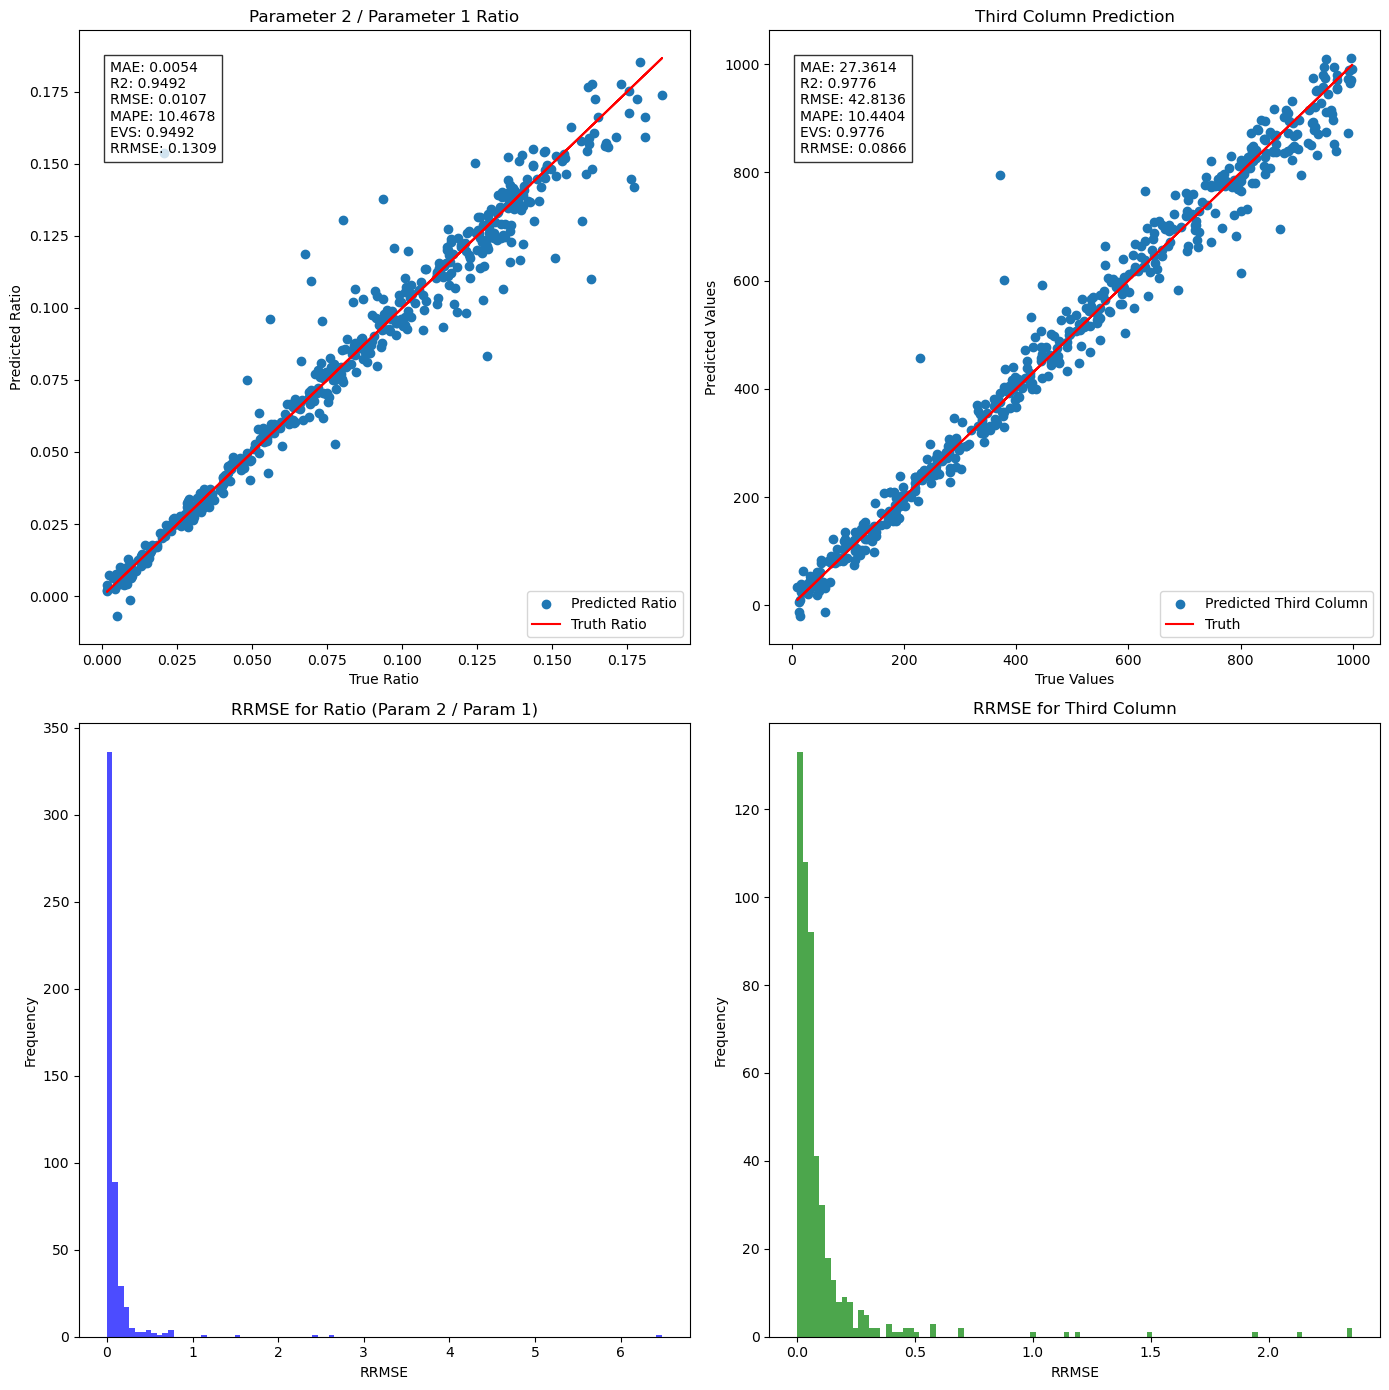

In [4]:

def plot_results_with_four_plots(metrics, all_true_values, all_predicted_means):
    fig, axes = plt.subplots(2, 2, figsize=(14, 14))  # 2x2 grid

    # Compute the ratio for true values (parameter 2 / parameter 1)
    true_ratio = all_true_values[:, 1] / all_true_values[:, 0]
    
    # Compute the ratio for predicted values (parameter 2 / parameter 1)
    predicted_ratio = all_predicted_means[:, 1] / all_predicted_means[:, 0]

    # Top left: Scatter plot for the true vs predicted ratio
    axes[0, 0].scatter(true_ratio, predicted_ratio, label='Predicted Ratio')
    axes[0, 0].plot(true_ratio, true_ratio, 'r-', label='Truth Ratio')  # Line representing perfect prediction
    axes[0, 0].set_title('Parameter 2 / Parameter 1 Ratio')
    axes[0, 0].set_xlabel('True Ratio')
    axes[0, 0].set_ylabel('Predicted Ratio')
    axes[0, 0].legend(loc='lower right')

    # Display metrics for the ratio
    ratio_metrics = compute_metrics(true_ratio.reshape(-1, 1), predicted_ratio.reshape(-1, 1))
    metrics_text_ratio = (
        f'MAE: {ratio_metrics[0]["mae"]:.4f}\n'
        f'R2: {ratio_metrics[0]["r2"]:.4f}\n'
        f'RMSE: {ratio_metrics[0]["rmse"]:.4f}\n'
        f'MAPE: {ratio_metrics[0]["mape"]:.4f}\n'
        f'EVS: {ratio_metrics[0]["evs"]:.4f}\n'
        f'RRMSE: {ratio_metrics[0]["rrmse"]:.4f}'
    )
    axes[0, 0].text(0.05, 0.95, metrics_text_ratio, transform=axes[0, 0].transAxes, verticalalignment='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

    # Top right: Scatter plot for the third parameter (column 3)
    true_third = all_true_values[:, 2]
    predicted_third = all_predicted_means[:, 2]

    axes[0, 1].scatter(true_third, predicted_third, label='Predicted Third Column')
    axes[0, 1].plot(true_third, true_third, 'r-', label='Truth')  # Line representing perfect prediction
    axes[0, 1].set_title('Third Column Prediction')
    axes[0, 1].set_xlabel('True Values')
    axes[0, 1].set_ylabel('Predicted Values')
    axes[0, 1].legend(loc='lower right')

    # Display metrics for the third column
    third_column_metrics = compute_metrics(true_third.reshape(-1, 1), predicted_third.reshape(-1, 1))
    metrics_text_third = (
        f'MAE: {third_column_metrics[0]["mae"]:.4f}\n'
        f'R2: {third_column_metrics[0]["r2"]:.4f}\n'
        f'RMSE: {third_column_metrics[0]["rmse"]:.4f}\n'
        f'MAPE: {third_column_metrics[0]["mape"]:.4f}\n'
        f'EVS: {third_column_metrics[0]["evs"]:.4f}\n'
        f'RRMSE: {third_column_metrics[0]["rrmse"]:.4f}'
    )
    axes[0, 1].text(0.05, 0.95, metrics_text_third, transform=axes[0, 1].transAxes, verticalalignment='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

    # Bottom left: Histogram of RRMSE for the ratio
    rrmse_ratio_per_prediction = np.abs((predicted_ratio - true_ratio) / true_ratio)  # RRMSE per prediction
    axes[1, 0].hist(rrmse_ratio_per_prediction, bins=100, color='blue', alpha=0.7)
    axes[1, 0].set_title('RRMSE for Ratio (Param 2 / Param 1)')
    axes[1, 0].set_xlabel('RRMSE')
    axes[1, 0].set_ylabel('Frequency')
    #axes[1, 0].set_xlim([0, .1])  # Set x-axis limit from 0 to 1

    # Bottom right: Histogram of RRMSE for the third column
    rrmse_third_per_prediction = np.abs((predicted_third - true_third) / true_third)  # RRMSE per prediction
    axes[1, 1].hist(rrmse_third_per_prediction, bins=100, color='green', alpha=0.7)
    axes[1, 1].set_title('RRMSE for Third Column')
    axes[1, 1].set_xlabel('RRMSE')
    axes[1, 1].set_ylabel('Frequency')
    #axes[1, 1].set_xlim([0, .1])  # Set x-axis limit from 0 to 1

    plt.tight_layout()
    return plt

# Call the function
plot = plot_results_with_four_plots(metrics, true_values, predictions)
plot.show()

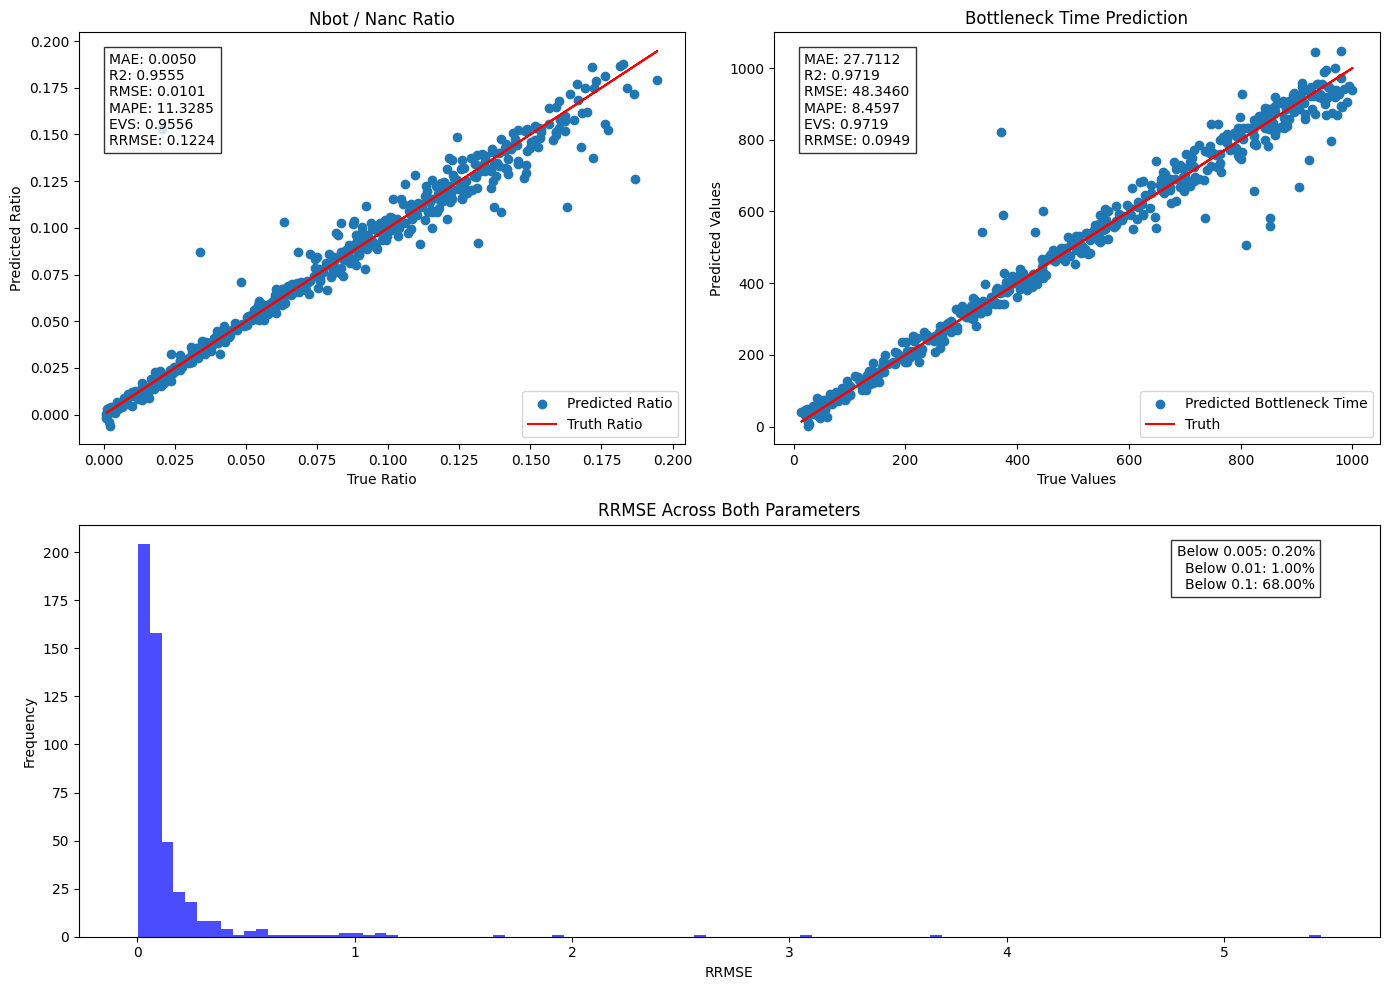

In [39]:
import matplotlib.gridspec as gridspec

def plot_results_with_rrmse_across_parameters(metrics, all_true_values, all_predicted_means):
    # Create a 2x2 grid layout, with the bottom row merged into one plot
    fig = plt.figure(figsize=(14, 10))
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])  # Define grid layout with 2 rows, 2 columns
    
    # Top left: Scatter plot for the ratio (Parameter 2 / Parameter 1)
    ax1 = fig.add_subplot(gs[0, 0])
    true_ratio = all_true_values[:, 1] / all_true_values[:, 0]
    predicted_ratio = all_predicted_means[:, 1] / all_predicted_means[:, 0]
    
    ax1.scatter(true_ratio, predicted_ratio, label='Predicted Ratio')
    ax1.plot(true_ratio, true_ratio, 'r-', label='Truth Ratio')  # Perfect prediction line
    ax1.set_title('Nbot / Nanc Ratio')
    ax1.set_xlabel('True Ratio')
    ax1.set_ylabel('Predicted Ratio')
    ax1.legend(loc='lower right')

    # Display metrics for the ratio
    ratio_metrics = compute_metrics(true_ratio.reshape(-1, 1), predicted_ratio.reshape(-1, 1))
    metrics_text_ratio = (
        f'MAE: {ratio_metrics[0]["mae"]:.4f}\n'
        f'R2: {ratio_metrics[0]["r2"]:.4f}\n'
        f'RMSE: {ratio_metrics[0]["rmse"]:.4f}\n'
        f'MAPE: {ratio_metrics[0]["mape"]:.4f}\n'
        f'EVS: {ratio_metrics[0]["evs"]:.4f}\n'
        f'RRMSE: {ratio_metrics[0]["rrmse"]:.4f}'
    )
    ax1.text(0.05, 0.95, metrics_text_ratio, transform=ax1.transAxes, verticalalignment='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

    # Top right: Scatter plot for the third parameter (Parameter 3)
    ax2 = fig.add_subplot(gs[0, 1])
    true_third = all_true_values[:, 2]
    predicted_third = all_predicted_means[:, 2]
    
    ax2.scatter(true_third, predicted_third, label='Predicted Bottleneck Time')
    ax2.plot(true_third, true_third, 'r-', label='Truth')  # Perfect prediction line
    ax2.set_title('Bottleneck Time Prediction')
    ax2.set_xlabel('True Values')
    ax2.set_ylabel('Predicted Values')
    ax2.legend(loc='lower right')

    # Display metrics for the third column
    third_column_metrics = compute_metrics(true_third.reshape(-1, 1), predicted_third.reshape(-1, 1))
    metrics_text_third = (
        f'MAE: {third_column_metrics[0]["mae"]:.4f}\n'
        f'R2: {third_column_metrics[0]["r2"]:.4f}\n'
        f'RMSE: {third_column_metrics[0]["rmse"]:.4f}\n'
        f'MAPE: {third_column_metrics[0]["mape"]:.4f}\n'
        f'EVS: {third_column_metrics[0]["evs"]:.4f}\n'
        f'RRMSE: {third_column_metrics[0]["rrmse"]:.4f}'
    )
    ax2.text(0.05, 0.95, metrics_text_third, transform=ax2.transAxes, verticalalignment='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

    # Bottom: Calculate RRMSE across all parameters and plot a single histogram
    ax3 = fig.add_subplot(gs[1, :])  # Span the bottom row across both columns

    # Calculate RRMSE per prediction
    rrmse_per_prediction = np.linalg.norm(((all_true_values - all_predicted_means) / all_true_values), axis=-1)
    
    # Calculate percentages of RRMSEs below thresholds
    below_005 = np.mean(rrmse_per_prediction < 0.005) * 100
    below_01 = np.mean(rrmse_per_prediction < 0.01) * 100
    below_1 = np.mean(rrmse_per_prediction < 0.1) * 100

    # Plot the histogram
    ax3.hist(rrmse_per_prediction, bins=100, color='blue', alpha=0.7)
    ax3.set_title('RRMSE Across Both Parameters')
    ax3.set_xlabel('RRMSE')
    ax3.set_ylabel('Frequency')

    # Add the calculated percentages as text on the histogram
    percentages_text = (
        f'Below 0.005: {below_005:.2f}%\n'
        f'Below 0.01: {below_01:.2f}%\n'
        f'Below 0.1: {below_1:.2f}%'
    )
    ax3.text(0.95, 0.95, percentages_text, transform=ax3.transAxes, verticalalignment='top', horizontalalignment='right', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    return plt

# Call the function
plot = plot_results_with_rrmse_across_parameters(metrics, true_values, predictions)
plot.show()


Training with sample size: 1000
Epoch 00309: reducing learning rate of group 0 to 8.0000e-04.
Epoch 00438: reducing learning rate of group 0 to 6.4000e-04.
Epoch 00600: reducing learning rate of group 0 to 5.1200e-04.
Epoch 00733: reducing learning rate of group 0 to 4.0960e-04.
Epoch 00845: reducing learning rate of group 0 to 3.2768e-04.
Epoch 00864: reducing learning rate of group 0 to 2.6214e-04.
Early stopping at epoch 873 with validation loss 0.0330
Metrics for sample size 1000: [{'mae': 208.91062890625, 'rmse': 457.14412321248795, 'r2': 0.9030685368972545, 'mape': 1.6999765474406823, 'evs': 0.9033828603710633, 'rrmse': 0.03632993289684042}, {'mae': 82.42844837379455, 'rmse': 137.42995898984697, 'r2': 0.9419616149661878, 'mape': 18.156115512769684, 'evs': 0.941967220952788, 'rrmse': 0.13515370036824498}, {'mae': 32.345931609153745, 'rmse': 51.77014889695585, 'r2': 0.9677671735909186, 'mape': 10.427170770318904, 'evs': 0.9677924402648064, 'rrmse': 0.10160213545791649}]
Nanc: 1373

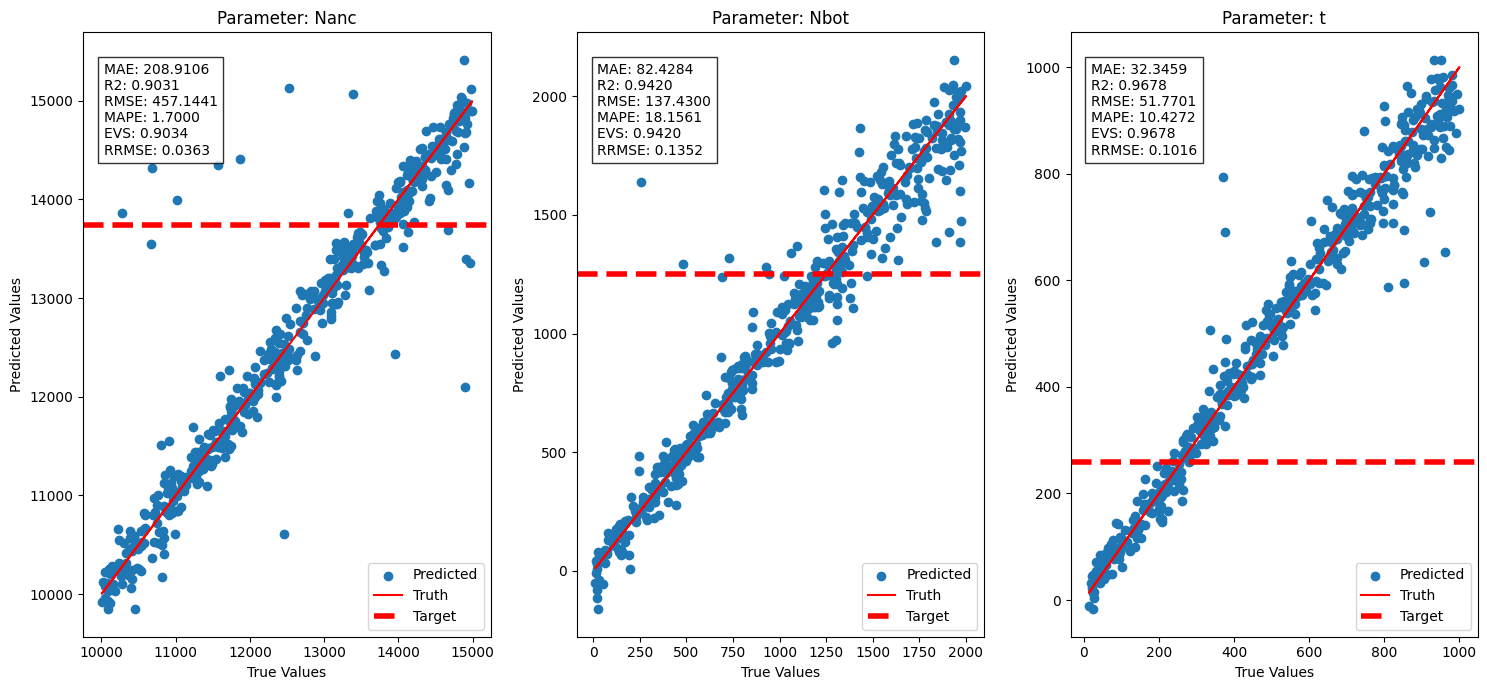


Training with sample size: 2000
Epoch 00331: reducing learning rate of group 0 to 8.0000e-04.
Epoch 00377: reducing learning rate of group 0 to 6.4000e-04.
Early stopping at epoch 386 with validation loss 0.0406
Metrics for sample size 2000: [{'mae': 187.042943359375, 'rmse': 354.4785426597155, 'r2': 0.941717470923479, 'mape': 1.5068766766788815, 'evs': 0.9417190060961856, 'rrmse': 0.028170944378981464}, {'mae': 77.7275702753067, 'rmse': 134.4796247337304, 'r2': 0.9444267926204701, 'mape': 22.471875133000157, 'evs': 0.9444277464556304, 'rrmse': 0.1322522326317465}, {'mae': 31.584586407184602, 'rmse': 54.73859555532589, 'r2': 0.9639648062106866, 'mape': 10.632803899995926, 'evs': 0.9639922568423348, 'rrmse': 0.10742789655595046}]
Nanc: 14053.30469
N_bot: 1077.96741
T: 287.36908


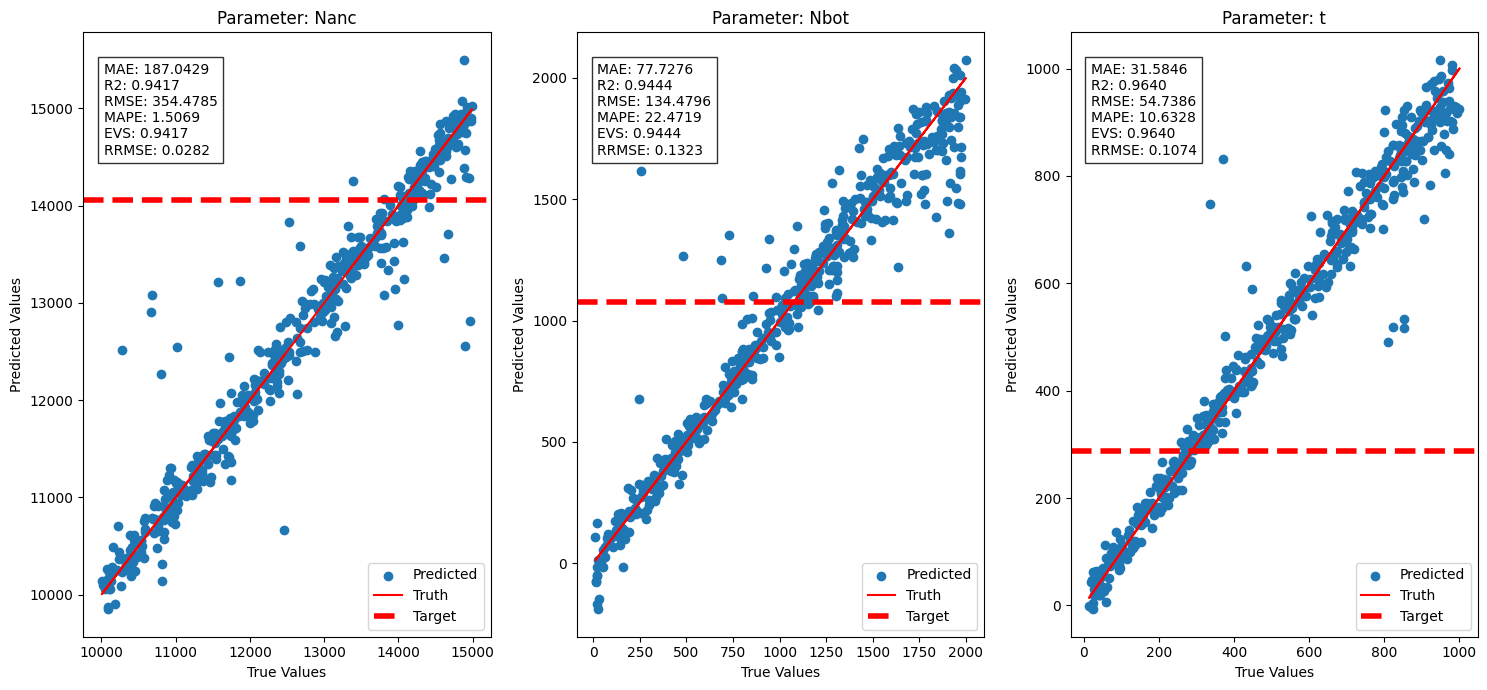


Training with sample size: 3000
Epoch 00384: reducing learning rate of group 0 to 8.0000e-04.
Early stopping at epoch 393 with validation loss 0.0414
Metrics for sample size 3000: [{'mae': 176.65229296875, 'rmse': 354.9897959073921, 'r2': 0.9415492315723321, 'mape': 1.4030323354432888, 'evs': 0.941588927380676, 'rrmse': 0.028211574445602156}, {'mae': 76.36801786851883, 'rmse': 135.67407014265066, 'r2': 0.9434352081814202, 'mape': 19.285991857571034, 'evs': 0.9435129022407241, 'rrmse': 0.13342689438737843}, {'mae': 31.937896743535994, 'rmse': 56.16917853235872, 'r2': 0.9620566470211627, 'mape': 9.887319854180076, 'evs': 0.9621387199126673, 'rrmse': 0.11023550457936154}]
Nanc: 14259.37500
N_bot: 1139.96973
T: 283.23843


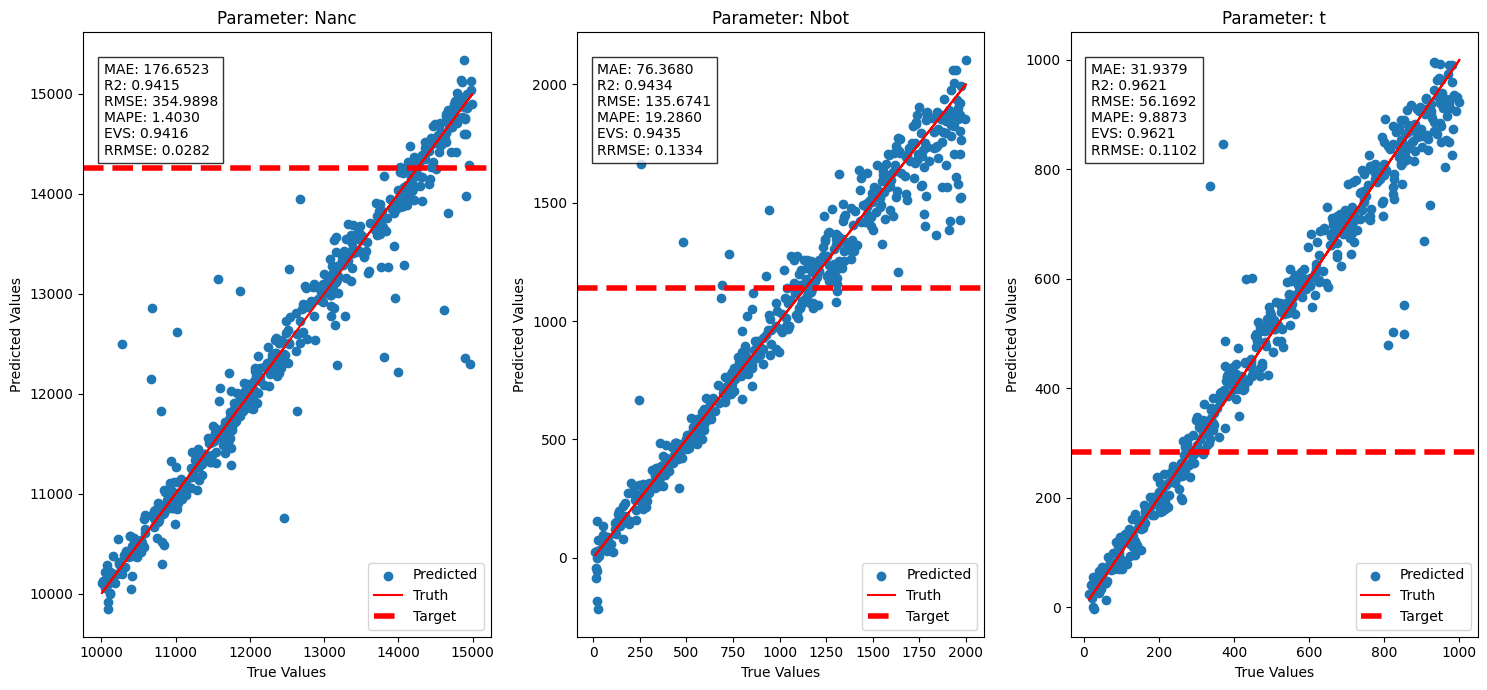


Training with sample size: 4000
Epoch 00358: reducing learning rate of group 0 to 8.0000e-04.
Epoch 00488: reducing learning rate of group 0 to 6.4000e-04.
Epoch 00501: reducing learning rate of group 0 to 5.1200e-04.
Epoch 00594: reducing learning rate of group 0 to 4.0960e-04.
Epoch 00777: reducing learning rate of group 0 to 3.2768e-04.
Epoch 00830: reducing learning rate of group 0 to 2.6214e-04.
Early stopping at epoch 839 with validation loss 0.0353
Metrics for sample size 4000: [{'mae': 174.250912109375, 'rmse': 354.07691761891687, 'r2': 0.9418494645975638, 'mape': 1.3995098495874925, 'evs': 0.941851949295442, 'rrmse': 0.02813902663129312}, {'mae': 71.95929114532471, 'rmse': 133.36517197947967, 'r2': 0.9453440629828066, 'mape': 16.499877094130643, 'evs': 0.945395891721462, 'rrmse': 0.13115623860882977}, {'mae': 29.69089446401596, 'rmse': 52.18855922870613, 'r2': 0.9672440517711864, 'mape': 10.02137101971268, 'evs': 0.967309185121029, 'rrmse': 0.10242329174410178}]
Nanc: 13870.6

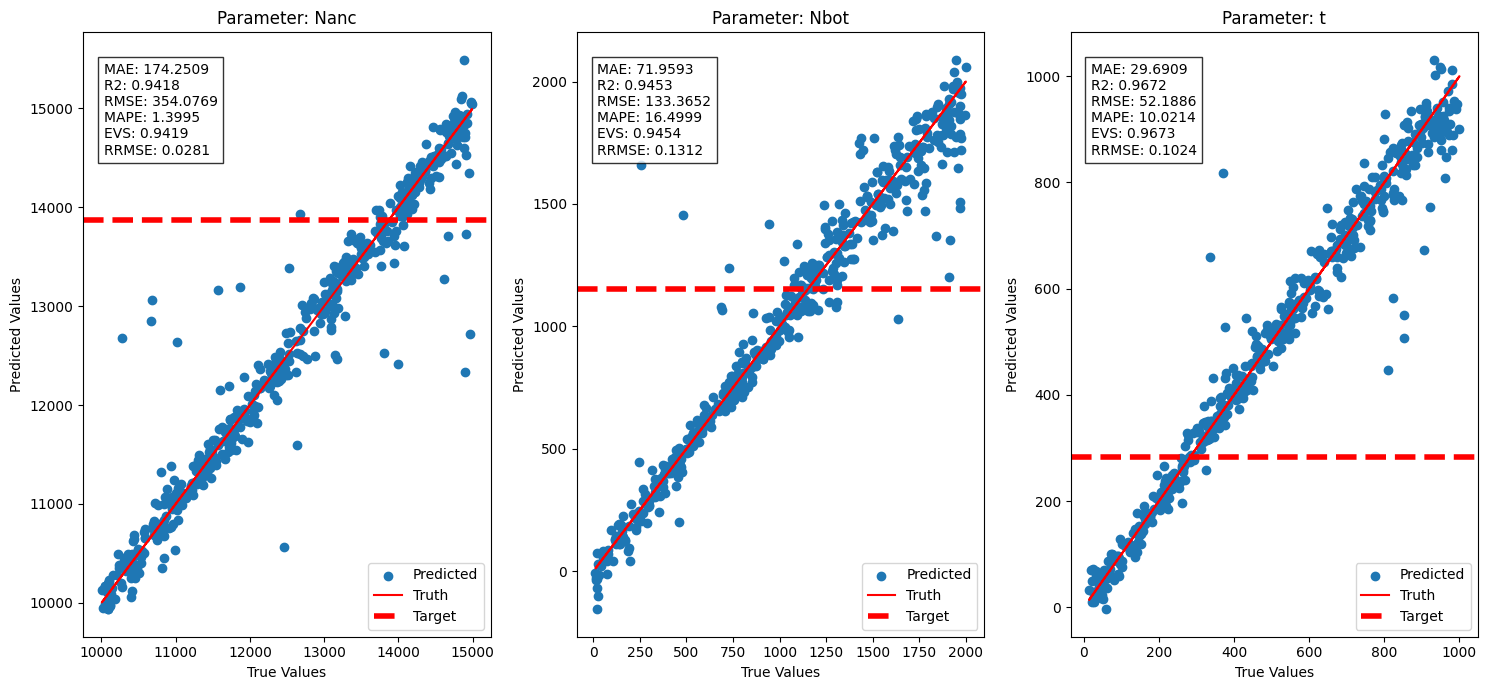


Training with sample size: 5000
Epoch 00385: reducing learning rate of group 0 to 8.0000e-04.
Epoch 00544: reducing learning rate of group 0 to 6.4000e-04.
Epoch 00709: reducing learning rate of group 0 to 5.1200e-04.
Early stopping at epoch 718 with validation loss 0.0330
Metrics for sample size 5000: [{'mae': 155.2601875, 'rmse': 349.011906335444, 'r2': 0.9435012327859131, 'mape': 1.2397739730061321, 'evs': 0.9435143636899703, 'rrmse': 0.027736502545984518}, {'mae': 69.48431677103042, 'rmse': 126.05449512162456, 'r2': 0.9511719747911498, 'mape': 18.68233235049544, 'evs': 0.9511799299626016, 'rrmse': 0.12396664882216171}, {'mae': 29.57603379011154, 'rmse': 52.323653108985084, 'r2': 0.9670742499756622, 'mape': 10.255389116990361, 'evs': 0.9670810483112909, 'rrmse': 0.10268842188214634}]
Nanc: 14134.00195
N_bot: 1081.87390
T: 253.71194


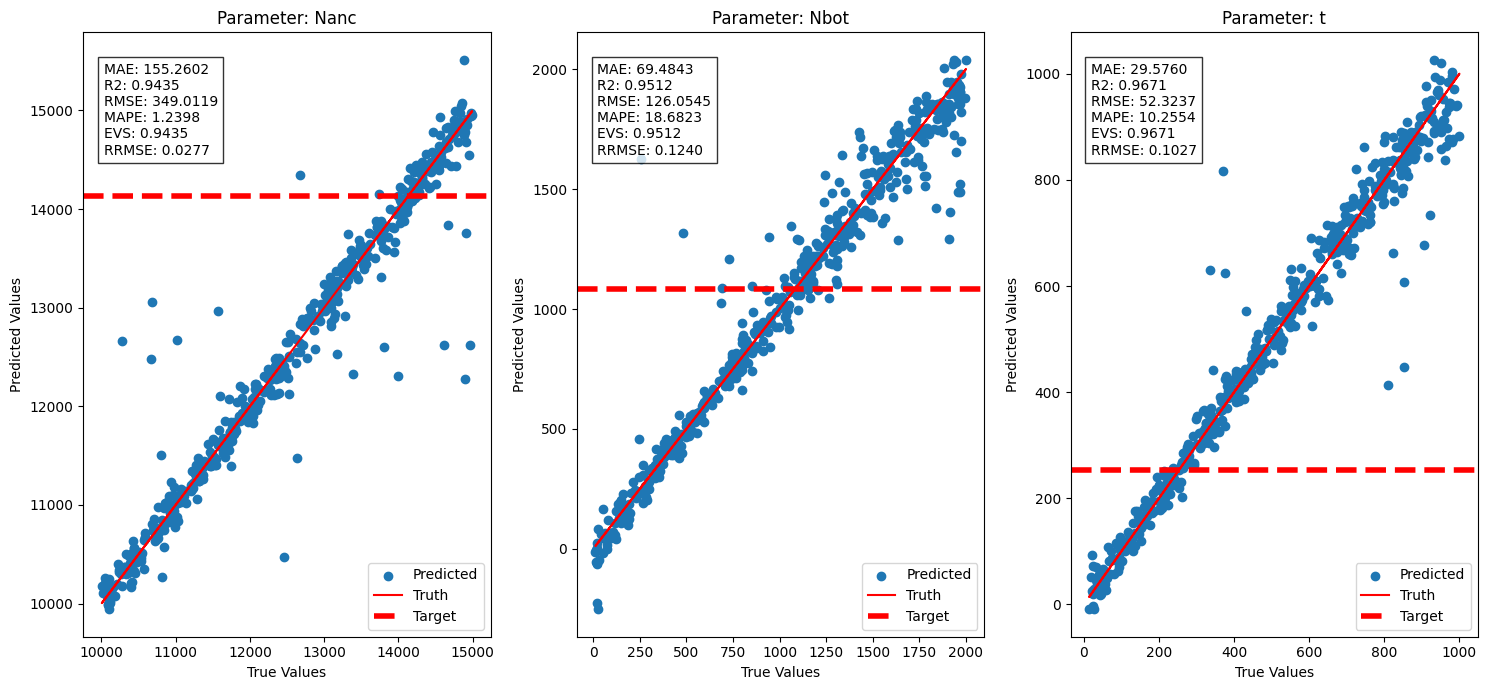


Training with sample size: 6000
Epoch 00370: reducing learning rate of group 0 to 8.0000e-04.
Epoch 00528: reducing learning rate of group 0 to 6.4000e-04.
Epoch 00693: reducing learning rate of group 0 to 5.1200e-04.
Epoch 00704: reducing learning rate of group 0 to 4.0960e-04.
Early stopping at epoch 704 with validation loss 0.0368
Metrics for sample size 6000: [{'mae': 159.74005859375, 'rmse': 351.98962582084874, 'r2': 0.9425330413518523, 'mape': 1.2690372170051032, 'evs': 0.9426061396606482, 'rrmse': 0.02797314640422807}, {'mae': 68.49946483278275, 'rmse': 123.14954193478245, 'r2': 0.9533965479724626, 'mape': 15.366373606719794, 'evs': 0.9534017167443903, 'rrmse': 0.12110981050623641}, {'mae': 29.489020166158674, 'rmse': 50.75138925990019, 'r2': 0.9690232799220031, 'mape': 9.633315590141574, 'evs': 0.9690339916748055, 'rrmse': 0.0996027563398612}]
Nanc: 14148.47363
N_bot: 1110.10974
T: 283.69238


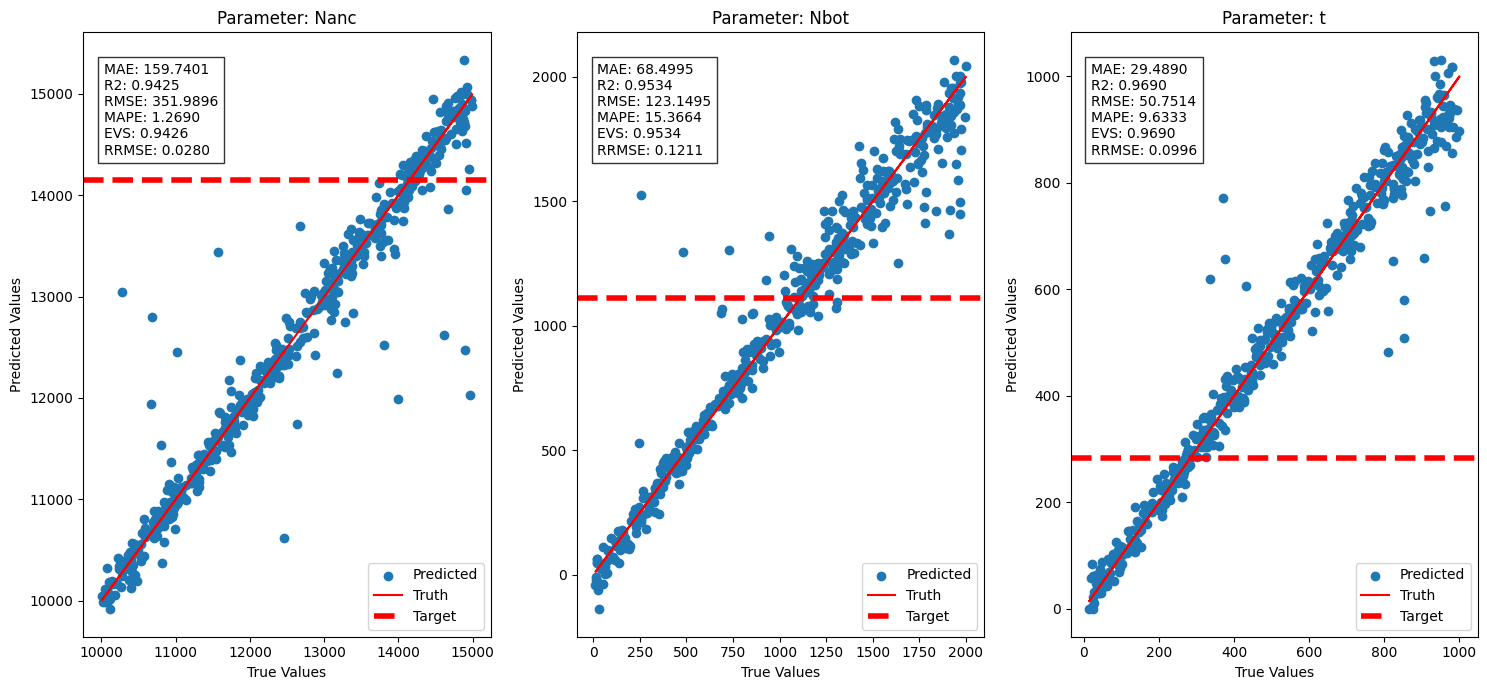


Training with sample size: 7000
Epoch 00446: reducing learning rate of group 0 to 8.0000e-04.
Epoch 00648: reducing learning rate of group 0 to 6.4000e-04.
Epoch 00659: reducing learning rate of group 0 to 5.1200e-04.
Epoch 01019: reducing learning rate of group 0 to 4.0960e-04.
Early stopping at epoch 1028 with validation loss 0.0336
Metrics for sample size 7000: [{'mae': 157.18094921875, 'rmse': 349.53663526940664, 'r2': 0.9433312166707482, 'mape': 1.2528601394606629, 'evs': 0.9433903964049531, 'rrmse': 0.027778203545717226}, {'mae': 65.91357915878297, 'rmse': 121.91935158632981, 'r2': 0.9543229787847899, 'mape': 13.115001223153092, 'evs': 0.9543440990917763, 'rrmse': 0.11989999585612102}, {'mae': 28.951651517868044, 'rmse': 49.301446197161376, 'r2': 0.9707679765048374, 'mape': 9.091109220740218, 'evs': 0.9708202196886456, 'rrmse': 0.09675715294474872}]
Nanc: 14102.58203
N_bot: 1001.60089
T: 239.15753


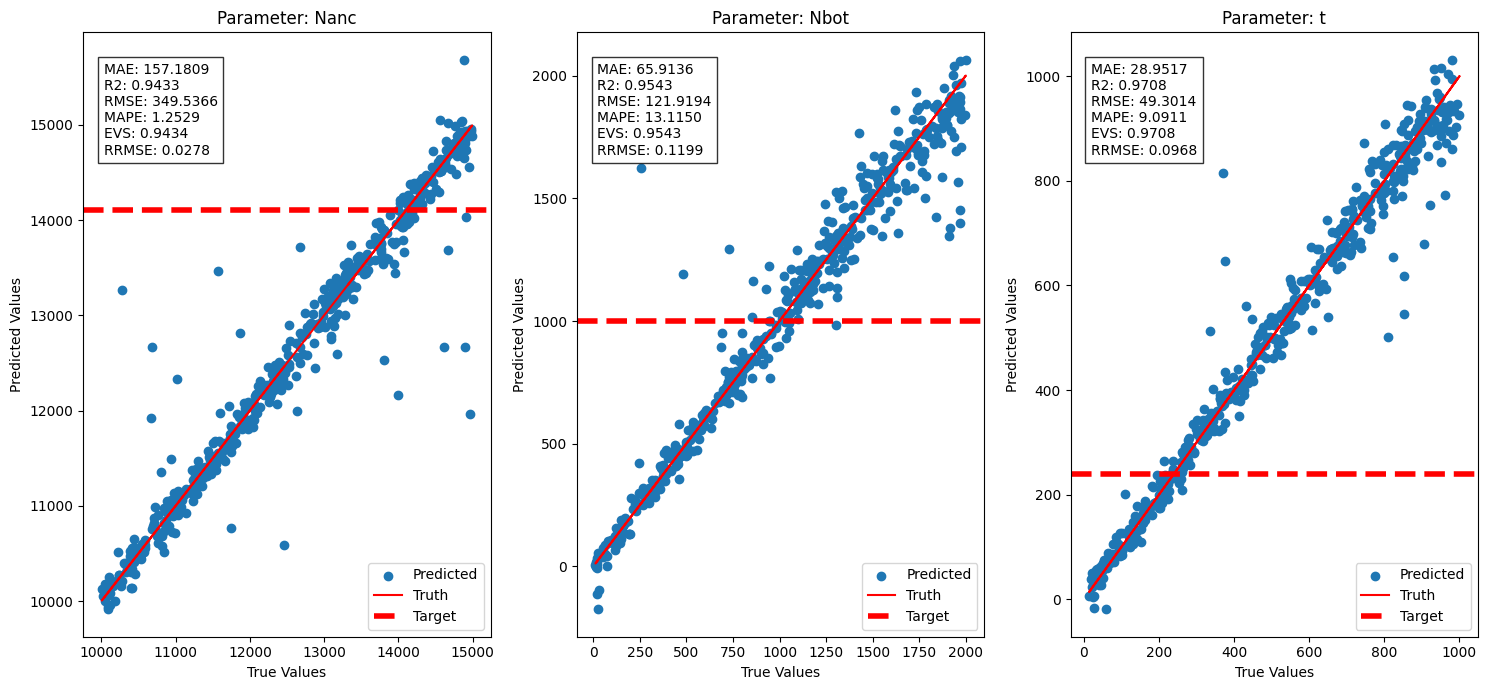


Training with sample size: 9000
Epoch 00403: reducing learning rate of group 0 to 8.0000e-04.
Epoch 00599: reducing learning rate of group 0 to 6.4000e-04.
Epoch 00803: reducing learning rate of group 0 to 5.1200e-04.
Early stopping at epoch 812 with validation loss 0.0341
Metrics for sample size 9000: [{'mae': 152.201400390625, 'rmse': 326.85558117229044, 'r2': 0.9504469607758333, 'mape': 1.216566923613811, 'evs': 0.9505025174886512, 'rrmse': 0.02597570597101948}, {'mae': 66.039897834301, 'rmse': 121.62110574065571, 'r2': 0.9545461807457293, 'mape': 13.433932843503932, 'evs': 0.9545598989356293, 'rrmse': 0.1196066898698674}, {'mae': 28.194661567211153, 'rmse': 49.42947728540901, 'r2': 0.9706159538903273, 'mape': 8.93664700005789, 'evs': 0.9706689968909011, 'rrmse': 0.0970084219143793}]
Nanc: 14016.05469
N_bot: 1232.77600
T: 285.53592


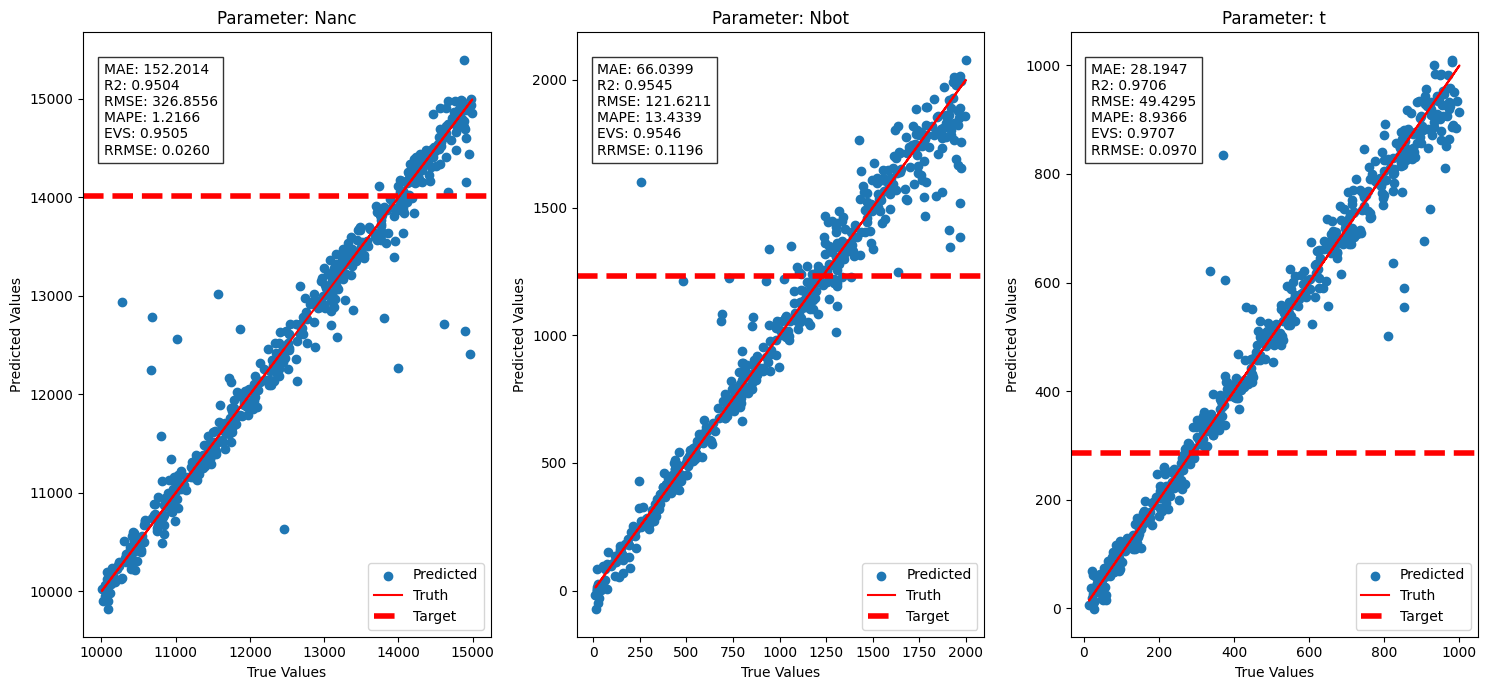


Training with sample size: 10000
Epoch 00422: reducing learning rate of group 0 to 8.0000e-04.
Epoch 00585: reducing learning rate of group 0 to 6.4000e-04.
Epoch 00759: reducing learning rate of group 0 to 5.1200e-04.
Epoch 00982: reducing learning rate of group 0 to 4.0960e-04.
Epoch 01180: reducing learning rate of group 0 to 3.2768e-04.
Epoch 01259: reducing learning rate of group 0 to 2.6214e-04.
Epoch 01372: reducing learning rate of group 0 to 2.0972e-04.
Epoch 01386: reducing learning rate of group 0 to 1.6777e-04.
Epoch 01401: reducing learning rate of group 0 to 1.3422e-04.
Epoch 01426: reducing learning rate of group 0 to 1.0737e-04.
Epoch 01471: reducing learning rate of group 0 to 8.5899e-05.
Epoch 01491: reducing learning rate of group 0 to 6.8719e-05.
Epoch 01511: reducing learning rate of group 0 to 5.4976e-05.
Epoch 01529: reducing learning rate of group 0 to 4.3980e-05.
Epoch 01551: reducing learning rate of group 0 to 3.5184e-05.
Epoch 01565: reducing learning rate 

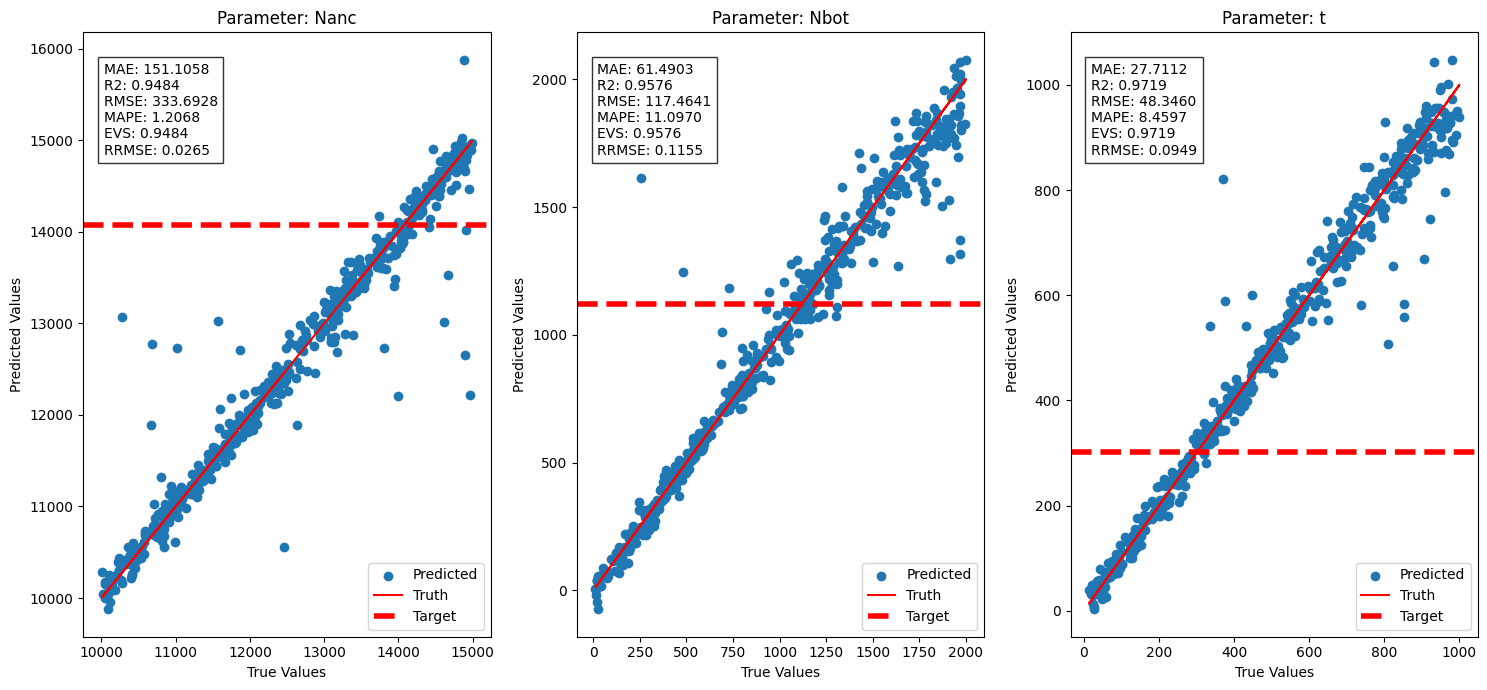

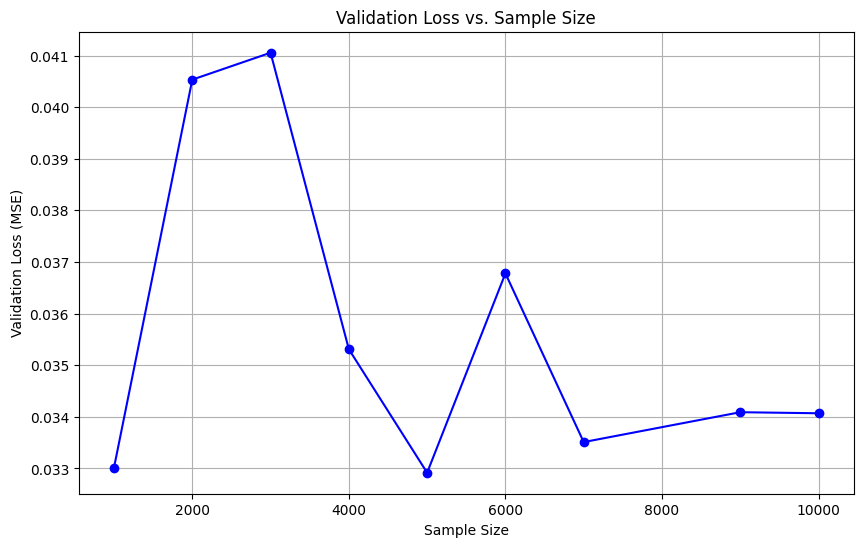

In [38]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, explained_variance_score

# List to store validation losses for each sample size
validation_losses = []

# Define a function to train and validate the model with different sample sizes
def train_with_sample_size(sample_size, X, y, feature_columns, parameter_columns):
    # Select the first `sample_size` samples for training
    X_sample, y_sample = X[:sample_size], y[:sample_size]

    # Split the sample data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

    # Scale both features and targets
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_val_scaled = scaler_X.transform(X_val)
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_val_scaled = scaler_y.transform(y_val)

    # Convert scaled data to tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32)

    # Define the model
    input_size = X_train.shape[1]
    output_size = y_train.shape[1]
    model = MLP(input_size, output_size)

    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=10, verbose=True)
    early_stopping_patience = 20
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    # Training loop with early stopping and learning rate scheduler
    num_epochs = 10000
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)

        # Learning rate scheduler step
        scheduler.step(val_loss)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch + 1} with validation loss {val_loss:.4f}")
            break

    # Append final validation loss to list for plotting
    validation_losses.append(best_val_loss.item())

    # Return the trained model and scalers for later use
    return model, scaler_X, scaler_y
df_remaining = df.iloc[500:, :]
# Initialize datasets
X = df_remaining[feature_columns].values
y = df_remaining[parameter_columns].values

# Sample sizes to experiment with
sample_sizes = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 9000, 10000]

# Loop through each sample size
for sample_size in sample_sizes:
    print(f"\nTraining with sample size: {sample_size}")
    model, scaler_X, scaler_y = train_with_sample_size(sample_size, X, y, feature_columns, parameter_columns)

    # Predict on the first 500 samples
    X_first_100 = df_first_100[feature_columns].values
    X_first_100_scaled = scaler_X.transform(X_first_100)
    X_first_100_tensor = torch.tensor(X_first_100_scaled, dtype=torch.float32)

    # Make predictions
    model.eval()
    with torch.no_grad():
        predictions_scaled = model(X_first_100_tensor).numpy()

    # Inverse transform the scaled predictions and true values
    predictions = scaler_y.inverse_transform(predictions_scaled)
    true_values = df_first_100[parameter_columns].values

    # Calculate metrics
    metrics = compute_metrics(true_values, predictions)
    print(f"Metrics for sample size {sample_size}: {metrics}")
    model.eval()
    with torch.no_grad():
        target_predictions_scaled = model(target_features_tensor).numpy()

    # Inverse transform to get predictions in the original scale
    target_predictions = scaler_y.inverse_transform(target_predictions_scaled)
    # Define the parameter names
    parameter_names = ['Nanc', 'N_bot', 'T']

    # Print each parameter with its value, ensuring no scientific notation
    for name, value in zip(parameter_names, target_predictions[0]):
        print(f"{name}: {value:.5f}")  # Adjust the number of decimals as needed
    # Plot results
    plot_results(metrics, true_values, predictions, parameter_columns, target_predictions[0])

# Plot validation loss vs. sample size
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, validation_losses, marker='o', linestyle='-', color='b')
plt.xlabel("Sample Size")
plt.ylabel("Validation Loss (MSE)")
plt.title("Validation Loss vs. Sample Size")
plt.grid()
plt.show()



In [5]:
from sklearn.metrics import mean_squared_error
import numpy as np

def permutation_feature_importance(model, X_val, y_val, scaler_y, baseline_loss=None, num_repeats=5):
    """
    Calculate permutation feature importance for an MLP model.

    Parameters:
        model: The trained MLP model.
        X_val (numpy.ndarray): Validation features.
        y_val (numpy.ndarray): True validation target values.
        scaler_y: Scaler used for the target variable (to inverse transform predictions).
        baseline_loss (float): Baseline loss with all features intact, if computed before.
        num_repeats (int): Number of times to shuffle each feature for robustness.
    
    Returns:
        importances (dict): Dictionary with features as keys and importance scores as values.
    """
    importances = {}
    y_val_pred = model(torch.tensor(X_val, dtype=torch.float32)).detach().numpy()
    y_val_pred = scaler_y.inverse_transform(y_val_pred)
    y_val_true = scaler_y.inverse_transform(y_val)

    # Calculate baseline loss if not provided
    if baseline_loss is None:
        baseline_loss = mean_squared_error(y_val_true, y_val_pred)
    
    # Iterate over each feature column
    for col in range(X_val.shape[1]):
        feature_name = feature_columns[col]
        losses = []
        
        # Shuffle the column values multiple times for robustness
        for _ in range(num_repeats):
            X_val_permuted = X_val.copy()
            np.random.shuffle(X_val_permuted[:, col])

            # Get model predictions with the permuted column
            y_val_permuted_pred = model(torch.tensor(X_val_permuted, dtype=torch.float32)).detach().numpy()
            y_val_permuted_pred = scaler_y.inverse_transform(y_val_permuted_pred)
            loss = mean_squared_error(y_val_true, y_val_permuted_pred)
            losses.append(loss)
        
        # Calculate the mean increase in loss due to feature permutation
        importances[feature_name] = np.mean(losses) - baseline_loss

    # Sort the importances by descending order
    importances = dict(sorted(importances.items(), key=lambda item: item[1], reverse=True))
    
    return importances

# Usage example:
print(len(X_val_scaled[1]))
feature_importances = permutation_feature_importance(model, X_val_scaled, y_val_scaled, scaler_y)
print("Permutation Feature Importances:", feature_importances)

85
Permutation Feature Importances: {'number_of_haplotypes_mean': np.float64(363819.2238725914), 'tajd_mean': np.float64(175642.46230502232), 'tajd_sd': np.float64(168319.22768096693), 'ld_decay_250bp': np.float64(144171.90088051284), 'number_of_haplotypes_median': np.float64(132454.51108372258), 'thetaw_sd': np.float64(91777.63602180185), 'haplotype_diversity_mean': np.float64(85085.02881435715), 'thetapi_sd': np.float64(76076.4339509808), 'ld_decay_850bp': np.float64(70283.9800773233), 'hprime_sd': np.float64(65556.78903759354), 'sfs_2': np.float64(65039.17609959257), 'ld_decay_450bp': np.float64(64352.2817526265), 'ld_decay_750bp': np.float64(58962.78350022288), 'haplotype_diversity_median': np.float64(56463.597274261585), 'ld_decay_50bp': np.float64(52394.5977650517), 'ld_decay_150bp': np.float64(50046.211262759665), 'faywuh_sd': np.float64(48001.69001582984), 'sfs_3': np.float64(46773.65750161285), 'ld_decay_350bp': np.float64(46036.625277998086), 'ld_decay_550bp': np.float64(3784

In [6]:
def gradient_feature_importance(model, X_val_tensor):
    """
    Calculate gradient-based feature importance for an MLP model.

    Parameters:
        model: The trained MLP model.
        X_val_tensor (torch.Tensor): Validation features as a PyTorch tensor.
    
    Returns:
        importances (dict): Dictionary with features as keys and average gradient magnitudes as values.
    """
    model.eval()
    X_val_tensor.requires_grad = True  # Enable gradient tracking on the input

    # Get model predictions
    y_pred = model(X_val_tensor)
    
    # Calculate gradients with respect to the input
    y_pred.sum().backward()  # Summing the output makes it easier to calculate gradients

    # Compute mean of absolute gradients for each feature
    importances = X_val_tensor.grad.abs().mean(dim=0).detach().numpy()
    
    # Map feature names to their importance scores
    importance_dict = dict(zip(feature_columns, importances))
    importance_dict = dict(sorted(importance_dict.items(), key=lambda item: item[1], reverse=True))
    
    return importance_dict

# Usage example:
grad_importances = gradient_feature_importance(model, X_val_tensor)
print("Gradient-Based Feature Importances:", grad_importances)

Gradient-Based Feature Importances: {'number_of_haplotypes_mean': np.float32(2.2027452), 'number_of_haplotypes_median': np.float32(1.1061211), 'haplotype_diversity_mean': np.float32(0.8343924), 'haplotype_diversity_median': np.float32(0.80910134), 'ld_decay_250bp': np.float32(0.5021444), 'haplotype_diversity_sd': np.float32(0.45013762), 'ld_decay_350bp': np.float32(0.43095884), 'tajd_mean': np.float32(0.4283959), 'haplotype_diversity_iqr': np.float32(0.40364727), 'ld_decay_50bp': np.float32(0.3972257), 'ld_decay_750bp': np.float32(0.38079572), 'ld_decay_850bp': np.float32(0.37011975), 'sfs_2': np.float32(0.3650304), 'ld_decay_450bp': np.float32(0.35990602), 'thetapi_mean': np.float32(0.31408685), 'thetaw_mean': np.float32(0.31383646), 'tajd_sd': np.float32(0.3048277), 'sfs_3': np.float32(0.29182643), 'faywuh_mean': np.float32(0.26499227), 'thetaw_sd': np.float32(0.25662866), 'ld_decay_950bp': np.float32(0.23337986), 'hprime_sd': np.float32(0.22110114), 'ld_decay_550bp': np.float32(0.22

In [10]:
# Number of top features to display
top_n = 10

# Create DataFrames from the importance dictionaries
perm_importance_df = pd.DataFrame(list(feature_importances.items()), columns=['Feature', 'Permutation Importance'])
grad_importance_df = pd.DataFrame(list(grad_importances.items()), columns=['Feature', 'Gradient-Based Importance'])

# Merge both DataFrames on 'Feature'
importance_df = pd.merge(perm_importance_df, grad_importance_df, on='Feature', how='inner')

# Sort by permutation importance and get top n features
top_features_df = importance_df.sort_values(by='Permutation Importance', ascending=False).head(top_n)

print("Top Features by Importance:")
print(top_features_df)

# Convert DataFrame to markdown-style table manually
markdown_table = "| Feature | Permutation Importance | Gradient-Based Importance |\n"
markdown_table += "|---------|------------------------|---------------------------|\n"

# Iterate through each row to add it to the table
for _, row in top_features_df.iterrows():
    markdown_table += f"| {row['Feature']} | {row['Permutation Importance']} | {row['Gradient-Based Importance']} |\n"

print(markdown_table)

Top Features by Importance:
                       Feature  Permutation Importance  \
0    number_of_haplotypes_mean           363819.223873   
1                    tajd_mean           175642.462305   
2                      tajd_sd           168319.227681   
3               ld_decay_250bp           144171.900881   
4  number_of_haplotypes_median           132454.511084   
5                    thetaw_sd            91777.636022   
6     haplotype_diversity_mean            85085.028814   
7                   thetapi_sd            76076.433951   
8               ld_decay_850bp            70283.980077   
9                    hprime_sd            65556.789038   

   Gradient-Based Importance  
0                   2.202745  
1                   0.428396  
2                   0.304828  
3                   0.502144  
4                   1.106121  
5                   0.256629  
6                   0.834392  
7                   0.211716  
8                   0.370120  
9                   0.2

In [28]:
# Create a directory for plots if it doesn't exist
os.makedirs(plot_dir, exist_ok=True)

# Plot top features against each target variable
for feature in top_features_df['Feature']:
    for i, target_name in enumerate(parameter_columns):  # parameter_columns holds target names like ['Nanc', 'N0', 'N1']
        plt.figure(figsize=(8, 6))
        
        # Scatter plot of the feature vs target
        plt.scatter(df[feature], df[target_name], alpha=0.6)
        plt.title(f"{feature} vs {target_name}")
        plt.xlabel(feature)
        plt.ylabel(target_name)
        
        # Save each plot
        plot_filename = os.path.join(plot_dir, f"{feature}_vs_{target_name}_1mil.png")
        plt.savefig(plot_filename)
        plt.close()
        print(f"Plot saved to {plot_filename}")

Plot saved to /nas/longleaf/home/adaigle/work/ghist_2024_work/bottleneck_testing_ground_pt2/bottleneck/plots/tajd_mean_vs_Nanc_1mil.png
Plot saved to /nas/longleaf/home/adaigle/work/ghist_2024_work/bottleneck_testing_ground_pt2/bottleneck/plots/tajd_mean_vs_N0_1mil.png
Plot saved to /nas/longleaf/home/adaigle/work/ghist_2024_work/bottleneck_testing_ground_pt2/bottleneck/plots/tajd_mean_vs_N1_1mil.png
Plot saved to /nas/longleaf/home/adaigle/work/ghist_2024_work/bottleneck_testing_ground_pt2/bottleneck/plots/number_of_haplotypes_mean_vs_Nanc_1mil.png
Plot saved to /nas/longleaf/home/adaigle/work/ghist_2024_work/bottleneck_testing_ground_pt2/bottleneck/plots/number_of_haplotypes_mean_vs_N0_1mil.png
Plot saved to /nas/longleaf/home/adaigle/work/ghist_2024_work/bottleneck_testing_ground_pt2/bottleneck/plots/number_of_haplotypes_mean_vs_N1_1mil.png
Plot saved to /nas/longleaf/home/adaigle/work/ghist_2024_work/bottleneck_testing_ground_pt2/bottleneck/plots/tajd_sd_vs_Nanc_1mil.png
Plot saved

In [13]:
import os
import matplotlib.pyplot as plt
plot_dir = '/nas/longleaf/home/adaigle/work/ghist_2024_work/bottleneck_testing_ground_pt2/bottleneck/plots/'

# Create a directory for plots if it doesn't exist
os.makedirs(plot_dir, exist_ok=True)

# Select the top two features
top_two_features = top_features_df['Feature'].head(2)

# Define the figure layout: 2 rows, 3 columns for each parameter
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

# Loop over each feature and each parameter to create plots
for row, feature in enumerate(top_two_features):
    for col, target_name in enumerate(parameter_columns):  # parameter_columns holds target names like ['Nanc', 'N0', 'N1']
        ax = axes[row, col]
        ax.scatter(df[feature], df[target_name], alpha=0.6)
        ax.set_title(f"{feature} vs {target_name}")
        ax.set_xlabel(feature)
        ax.set_ylabel(target_name)

# Adjust layout to prevent overlap and save the combined plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the suptitle
combined_plot_filename = os.path.join(plot_dir, "top_two_features_vs_parameters.png")
plt.savefig(combined_plot_filename)
plt.close()
print(f"Combined plot saved to {combined_plot_filename}")


Combined plot saved to /nas/longleaf/home/adaigle/work/ghist_2024_work/bottleneck_testing_ground_pt2/bottleneck/plots/top_two_features_vs_parameters.png


In [16]:
def permutation_importance_per_target(model, X_val, y_val, scaler_y, target_names, num_repeats=5):
    """
    Calculate permutation feature importance separately for each target variable.
    
    Parameters:
        model: Trained MLP model.
        X_val (numpy.ndarray): Validation features.
        y_val (numpy.ndarray): True validation target values.
        scaler_y: Scaler for the target variable.
        target_names (list): List of target parameter names.
        num_repeats (int): Number of times to shuffle each feature for robustness.
    
    Returns:
        importances (dict): Dictionary where keys are target names and values are dictionaries
                            of feature importances for each target.
    """
    importances = {target: {} for target in target_names}
    y_val_true = scaler_y.inverse_transform(y_val)

    # Predict for all targets with unshuffled data to get baseline performance
    y_val_pred = model(torch.tensor(X_val, dtype=torch.float32)).detach().numpy()
    y_val_pred = scaler_y.inverse_transform(y_val_pred)
    baseline_losses = [mean_squared_error(y_val_true[:, i], y_val_pred[:, i]) for i in range(y_val_true.shape[1])]
    
    # Loop over each feature column
    for col in range(X_val.shape[1]):
        feature_name = feature_columns[col]
        
        # Shuffle the column values multiple times and compute the loss increase per target
        for target_idx, target_name in enumerate(target_names):
            losses = []
            for _ in range(num_repeats):
                X_val_permuted = X_val.copy()
                np.random.shuffle(X_val_permuted[:, col])

                # Get model predictions with the permuted column
                y_val_permuted_pred = model(torch.tensor(X_val_permuted, dtype=torch.float32)).detach().numpy()
                y_val_permuted_pred = scaler_y.inverse_transform(y_val_permuted_pred)
                
                # Calculate loss for the specific target variable
                loss = mean_squared_error(y_val_true[:, target_idx], y_val_permuted_pred[:, target_idx])
                losses.append(loss)

            # Calculate mean importance for this feature on this target
            importances[target_name][feature_name] = np.mean(losses) - baseline_losses[target_idx]

    return importances

# Usage example:
target_importances_perm = permutation_importance_per_target(model, X_val_scaled, y_val_scaled, scaler_y, parameter_columns)
print("Permutation Feature Importances per Target:")
for target, feature_importances in target_importances_perm.items():
    sorted_importances = sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)
    print(f"Target: {target}")
    for feature, importance in sorted_importances[:10]:  # Display top 10 features per target
        print(f"  Feature: {feature}, Importance: {importance:.4f}")

Permutation Feature Importances per Target:
Target: Nanc
  Feature: ld_decay_250bp, Importance: 469568.5274
  Feature: thetaw_sd, Importance: 455333.6685
  Feature: tajd_mean, Importance: 428576.6058
  Feature: tajd_sd, Importance: 411860.6555
  Feature: ld_decay_750bp, Importance: 298325.6976
  Feature: ld_decay_550bp, Importance: 287775.6961
  Feature: ld_decay_50bp, Importance: 271989.8076
  Feature: ld_decay_950bp, Importance: 179445.4786
  Feature: hprime_sd, Importance: 159166.5152
  Feature: thetapi_sd, Importance: 152112.6915
Target: N0
  Feature: number_of_haplotypes_mean, Importance: 1155392.2902
  Feature: number_of_haplotypes_median, Importance: 421411.7307
  Feature: sfs_2, Importance: 263054.8362
  Feature: haplotype_diversity_median, Importance: 127668.5568
  Feature: sfs_3, Importance: 117578.2081
  Feature: haplotype_diversity_mean, Importance: 99361.6178
  Feature: haplotype_diversity_iqr, Importance: 52196.9251
  Feature: thetaw_mean, Importance: 49067.6141
  Feature

In [17]:
def gradient_importance_per_target(model, X_val_tensor, target_names):
    """
    Calculate gradient-based feature importance separately for each target variable.
    
    Parameters:
        model: Trained MLP model.
        X_val_tensor (torch.Tensor): Validation features as a PyTorch tensor.
        target_names (list): List of target parameter names.
    
    Returns:
        importances (dict): Dictionary where keys are target names and values are dictionaries
                            of feature importances for each target.
    """
    model.eval()
    X_val_tensor.requires_grad = True

    # Dictionary to hold the importance for each target
    importances = {target: {} for target in target_names}

    # Loop over each target parameter
    for target_idx, target_name in enumerate(target_names):
        model.zero_grad()  # Reset gradients for each target
        y_pred = model(X_val_tensor)[:, target_idx].sum()  # Focus on one target at a time
        y_pred.backward()  # Compute gradients with respect to input
        
        # Get mean absolute gradients for each feature for this specific target
        abs_gradients = X_val_tensor.grad.abs().mean(dim=0).detach().numpy()
        
        # Store feature importances for this target
        for feature_idx, feature_name in enumerate(feature_columns):
            importances[target_name][feature_name] = abs_gradients[feature_idx]
        
        # Clear gradients after each target
        X_val_tensor.grad.zero_()

    # Sort importances for each target by value
    for target in importances:
        importances[target] = dict(sorted(importances[target].items(), key=lambda item: item[1], reverse=True))
    
    return importances

# Usage example:
target_importances_grad = gradient_importance_per_target(model, X_val_tensor, parameter_columns)
print("Gradient-Based Feature Importances per Target:")
for target, feature_importances in target_importances_grad.items():
    print(f"Target: {target}")
    for feature, importance in list(feature_importances.items())[:10]:  # Top 10 features per target
        print(f"  Feature: {feature}, Importance: {importance:.4f}")

Gradient-Based Feature Importances per Target:
Target: Nanc
  Feature: number_of_haplotypes_mean, Importance: 2.4157
  Feature: number_of_haplotypes_median, Importance: 1.0916
  Feature: haplotype_diversity_mean, Importance: 0.9098
  Feature: haplotype_diversity_median, Importance: 0.8693
  Feature: ld_decay_250bp, Importance: 0.8547
  Feature: ld_decay_50bp, Importance: 0.7404
  Feature: ld_decay_550bp, Importance: 0.6866
  Feature: tajd_mean, Importance: 0.6456
  Feature: ld_decay_950bp, Importance: 0.6062
  Feature: ld_decay_150bp, Importance: 0.5794
Target: N0
  Feature: number_of_haplotypes_mean, Importance: 1.2498
  Feature: number_of_haplotypes_median, Importance: 0.6051
  Feature: haplotype_diversity_median, Importance: 0.4989
  Feature: haplotype_diversity_mean, Importance: 0.4022
  Feature: sfs_2, Importance: 0.3419
  Feature: haplotype_diversity_iqr, Importance: 0.2770
  Feature: sfs_3, Importance: 0.2046
  Feature: haplotype_diversity_sd, Importance: 0.2025
  Feature: tajd_

In [19]:
# Convert dictionaries to DataFrames and format for presentation
perm_importances_df = pd.DataFrame(target_importances_perm).fillna(0)
grad_importances_df = pd.DataFrame(target_importances_grad).fillna(0)

# Combine the two tables for easy comparison
combined_importances_df = pd.concat([perm_importances_df, grad_importances_df], axis=1, keys=["Permutation", "Gradient"])
print("Combined Feature Importance Summary Table:")
print(combined_importances_df.head(100))  # Display top 10 rows

Combined Feature Importance Summary Table:
                 Permutation                              Gradient            \
                        Nanc            N0            N1      Nanc        N0   
thetapi_mean    9.466712e+03    742.696537  2.526765e+03  0.130984  0.036254   
thetapi_median  1.635823e+04    795.439366  2.331450e+03  0.152218  0.033082   
thetapi_sd      1.521127e+05    514.404649  1.103289e+03  0.268722  0.030161   
thetapi_iqr     5.263449e+03    689.197065  5.853924e+02  0.088164  0.031711   
hprime_mean     1.507401e+05   1332.411342  3.497974e+02  0.318654  0.034492   
...                      ...           ...           ...       ...       ...   
ld_decay_750bp  2.983257e+05    359.335632  2.059449e+03  0.549245  0.029146   
ld_decay_850bp  1.086765e+05   2624.470745  2.402296e+03  0.426556  0.057872   
ld_decay_950bp  1.794455e+05   9342.153245  2.733089e+03  0.606237  0.085980   
num_samples    -1.455192e-11      0.000000  2.273737e-13  0.101971  0.064474 